In [1]:
import pandas as pd
df = pd.read_csv("/home/marko/projects/tf216/br/brfinal.csv")

In [2]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
for idx, col_name in enumerate(df.columns):
    print(f"Index: {idx}, Column Name: {col_name}")

Index: 0, Column Name: RHUM
Index: 1, Column Name: MAX
Index: 2, Column Name: MIN
Index: 3, Column Name: TEMP
Index: 4, Column Name: WDSP


In [3]:
ry = pd.read_csv("/home/marko/projects/tf216/br/rybr.csv")
ry['DATE'] = pd.to_datetime(ry['DATE'])
ry = ry.set_index('DATE')
ry.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-01-01 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RHUM    365 non-null    float64
 1   MAX     365 non-null    float64
 2   MIN     365 non-null    float64
 3   TEMP    365 non-null    float64
 4   WDSP    365 non-null    float64
dtypes: float64(5)
memory usage: 17.1 KB


In [4]:
df_train = df["2002-01-01":"2019-12-31"]
df_valid = df["2020-01-01":"2023-12-31"]
df_test = df["2024-01-01":"2024-12-31"]

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

def split_inputs_and_targets(time_series):
    ahead = 365
    target_cols = tf.constant([1, 2, 3], dtype=tf.int32)
    X = time_series[:, :-ahead]
    Y = tf.gather(time_series[:, -ahead:], target_cols, axis=-1)
    return X, Y


seq_length = 365
train_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_train.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=True,
	seed=42
).map(split_inputs_and_targets)


valid_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_valid.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=False
).map(split_inputs_and_targets)

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

df_test = df_test.drop(pd.to_datetime("2024-02-29"))

X = df_valid.to_numpy()[np.newaxis, :seq_length]
Y_test = df_test.iloc[:, [1, 2, 3]].to_numpy()

Y_ref = ry.iloc[:, [1, 2, 3]].to_numpy()

mae_ref = mean_absolute_error(Y_test[:, 2], Y_ref[:, 2])
print(f'Mean Absolute Error (MAE): {mae_ref:.3f}')

rmse_ref = np.sqrt(mean_squared_error(Y_test[:, 2], Y_ref[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_ref:.3f}')

Mean Absolute Error (MAE): 2.516
Root Mean Squared Error (RMSE): 3.148


In [7]:
lstm_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_32.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_32 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=80)
lstm_32.save('models/lstm_32.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 314.8490 - mae: 16.1061 - val_loss: 185.5643 - val_mae: 11.6720
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 151.0871 - mae: 10.3492 - val_loss: 100.4992 - val_mae: 8.0913
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 83.9104 - mae: 7.4051 - val_loss: 64.2183 - val_mae: 6.4370
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 56.3802 - mae: 6.1256 - val_loss: 50.2165 - val_mae: 5.8616
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 46.4485 - mae: 5.6992 - val_loss: 45.3917 - val_mae: 5.6974
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 43.2834 - mae: 5.5777 - val_loss: 43.9108 - val_mae: 5.6525
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.4201 - mae: 5.5461 - val_loss: 43.4973 - val_mae: 5.6415
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 42.2446 - mae: 5.5419 - val_loss: 43.3845 - val_mae: 5.6396
Epoch 9/80
183/183 ━━━━━━

In [9]:
from tensorflow.keras.models import load_model
lstm_32 = load_model('models/lstm_32.keras')
history_lstm_32_2 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_32.save('models/lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 6.9622 - mae: 2.0185 - val_loss: 6.4420 - val_mae: 1.9791
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 6.9739 - mae: 2.0207 - val_loss: 6.4802 - val_mae: 1.9861
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.9287 - mae: 2.0129 - val_loss: 6.5959 - val_mae: 2.0054
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.9063 - mae: 2.0089 - val_loss: 6.5194 - val_mae: 1.9911
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.9090 - mae: 2.0092 - val_loss: 6.4734 - val_mae: 1.9809
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.8857 - mae: 2.0056 - val_loss: 6.3811 - val_mae: 1.9672
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.8907 - mae: 2.0062 - val_loss: 6.4340 - val_mae: 1.9783
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.8577 - mae: 2.0006 - val_loss: 6.4563 - val_mae: 1.9804
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/

In [11]:
from tensorflow.keras.models import load_model
lstm_32 = load_model('models/lstm_32.keras')
history_lstm_32_3 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_32.save('models/lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 6.8174 - mae: 1.9940 - val_loss: 6.3827 - val_mae: 1.9673
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.8127 - mae: 1.9930 - val_loss: 6.4915 - val_mae: 1.9875
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 6.8110 - mae: 1.9928 - val_loss: 6.5178 - val_mae: 1.9906
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.7914 - mae: 1.9897 - val_loss: 6.2844 - val_mae: 1.9517
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 6.7974 - mae: 1.9906 - val_loss: 6.2987 - val_mae: 1.9537
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.7618 - mae: 1.9846 - val_loss: 6.3274 - val_mae: 1.9597
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 6.7810 - mae: 1.9876 - val_loss: 6.3147 - val_mae: 1.9581
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.7810 - mae: 1.9878 - val_loss: 6.3623 - val_mae: 1.9652
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/

In [13]:
from tensorflow.keras.models import load_model
lstm_32 = load_model('models/lstm_32.keras')
history_lstm_32_4 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_32.save('models/lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 6.7440 - mae: 1.9817 - val_loss: 6.3221 - val_mae: 1.9602
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.7322 - mae: 1.9798 - val_loss: 6.4370 - val_mae: 1.9787
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.7141 - mae: 1.9770 - val_loss: 6.2219 - val_mae: 1.9420
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.6969 - mae: 1.9737 - val_loss: 6.1842 - val_mae: 1.9347
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.7111 - mae: 1.9758 - val_loss: 6.1778 - val_mae: 1.9328
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.6937 - mae: 1.9728 - val_loss: 6.4638 - val_mae: 1.9841
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.7011 - mae: 1.9739 - val_loss: 6.2361 - val_mae: 1.9436
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.6663 - mae: 1.9686 - val_loss: 6.2489 - val_mae: 1.9458
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/

In [15]:
from tensorflow.keras.models import load_model
lstm_32 = load_model('models/lstm_32.keras')
history_lstm_32_5 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_32.save('models/lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.6461 - mae: 1.9646 - val_loss: 6.1897 - val_mae: 1.9348
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 6.6441 - mae: 1.9651 - val_loss: 6.3245 - val_mae: 1.9604
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 6.6457 - mae: 1.9648 - val_loss: 6.1996 - val_mae: 1.9380
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.6285 - mae: 1.9622 - val_loss: 6.1772 - val_mae: 1.9342
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.6211 - mae: 1.9613 - val_loss: 6.1588 - val_mae: 1.9328
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.6091 - mae: 1.9594 - val_loss: 6.2827 - val_mae: 1.9533
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.6149 - mae: 1.9604 - val_loss: 6.1460 - val_mae: 1.9284
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.6069 - mae: 1.9587 - val_loss: 6.2832 - val_mae: 1.9523
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/

In [16]:
lstm_32 = tf.keras.models.load_model('models/lstm_32.keras')

Y_lstm_32 = lstm_32.predict(X)  # shape: (1, 365, 3)
Y_lstm_32 = Y_lstm_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_32_pred.csv')

mae_lstm_32 = mean_absolute_error(Y_test[:, 2], Y_lstm_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_32:.3f}')

rmse_lstm_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Mean Absolute Error (MAE): 2.403
Root Mean Squared Error (RMSE): 2.887


In [17]:
conv_lstm_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_32.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_32 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=80)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 313.3268 - mae: 16.0633 - val_loss: 191.1761 - val_mae: 11.8903
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 156.2644 - mae: 10.5634 - val_loss: 104.4882 - val_mae: 8.2715
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 87.1358 - mae: 7.5556 - val_loss: 66.2747 - val_mae: 6.5286
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 57.9695 - mae: 6.1986 - val_loss: 51.1063 - val_mae: 5.8945
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 47.0495 - mae: 5.7231 - val_loss: 45.7246 - val_mae: 5.7076
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 43.4745 - mae: 5.5838 - val_loss: 44.0217 - val_mae: 5.6558
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 42.4857 - mae: 5.5484 - val_loss: 43.5306 - val_mae: 5.6421
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 42.2607 - mae: 5.5421 - val_loss: 43.3974 - val_mae: 5.6398
Epoch 9/80
183/183 ━━━━━━

In [19]:
from tensorflow.keras.models import load_model
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_2 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.8977 - mae: 2.0092 - val_loss: 6.5459 - val_mae: 1.9968
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.8771 - mae: 2.0056 - val_loss: 6.2254 - val_mae: 1.9425
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.8417 - mae: 1.9995 - val_loss: 6.2297 - val_mae: 1.9445
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.8348 - mae: 1.9987 - val_loss: 6.3003 - val_mae: 1.9544
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.8269 - mae: 1.9968 - val_loss: 6.2647 - val_mae: 1.9510
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.8174 - mae: 1.9953 - val_loss: 6.2724 - val_mae: 1.9513
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.8079 - mae: 1.9946 - val_loss: 6.1191 - val_mae: 1.9231
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.7955 - mae: 1.9922 - val_loss: 6.2726 - val_mae: 1.9518
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/

In [21]:
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_3 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.7548 - mae: 1.9855 - val_loss: 6.1835 - val_mae: 1.9336
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.7347 - mae: 1.9814 - val_loss: 5.9924 - val_mae: 1.9010
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.7311 - mae: 1.9813 - val_loss: 6.0757 - val_mae: 1.9153
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.7252 - mae: 1.9802 - val_loss: 6.0608 - val_mae: 1.9110
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.7055 - mae: 1.9765 - val_loss: 6.4061 - val_mae: 1.9739
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.6903 - mae: 1.9737 - val_loss: 5.9950 - val_mae: 1.8969
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.6758 - mae: 1.9710 - val_loss: 6.1254 - val_mae: 1.9178
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.6410 - mae: 1.9655 - val_loss: 6.0763 - val_mae: 1.9069
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/

In [23]:
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_4 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.6165 - mae: 1.9613 - val_loss: 5.9996 - val_mae: 1.8888
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.6011 - mae: 1.9599 - val_loss: 5.9557 - val_mae: 1.8824
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.5723 - mae: 1.9544 - val_loss: 6.0077 - val_mae: 1.8927
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.5595 - mae: 1.9530 - val_loss: 6.2997 - val_mae: 1.9421
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.5811 - mae: 1.9560 - val_loss: 6.1362 - val_mae: 1.9163
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.5462 - mae: 1.9504 - val_loss: 6.0500 - val_mae: 1.8986
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.5382 - mae: 1.9489 - val_loss: 6.0265 - val_mae: 1.8927
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.5292 - mae: 1.9476 - val_loss: 6.1510 - val_mae: 1.9133
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/

In [24]:
conv_lstm_32 = tf.keras.models.load_model('models/conv_lstm_32.keras')

Y_conv_lstm_32 = conv_lstm_32.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_32 = Y_conv_lstm_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_32_pred.csv')

mae_conv_lstm_32 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_32:.3f}')

rmse_conv_lstm_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Mean Absolute Error (MAE): 2.402
Root Mean Squared Error (RMSE): 2.875


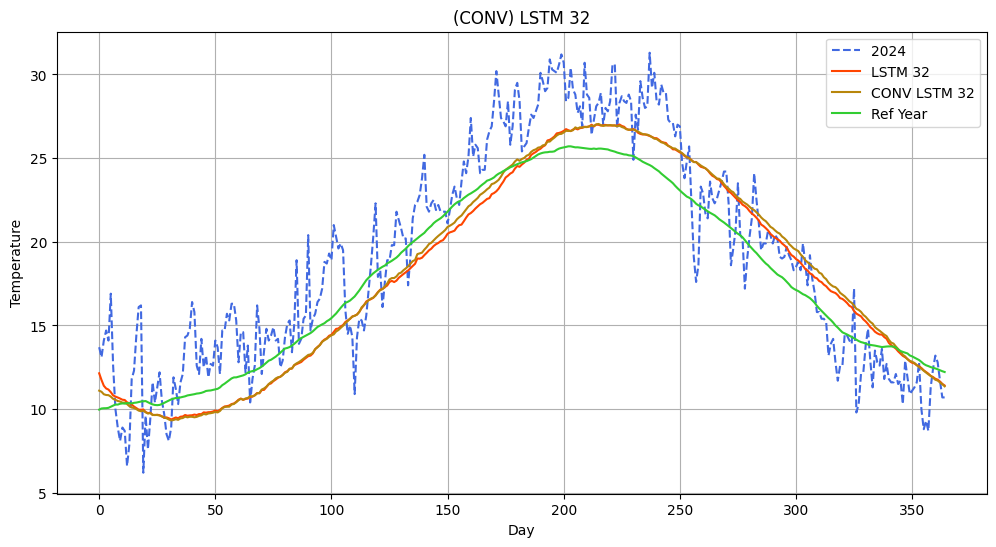

In [25]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_32[:, 2], label="LSTM 32", color='orangered')
plt.plot(x, Y_conv_lstm_32[:, 2], label="CONV LSTM 32", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [26]:
lstm_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_64.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_64 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=80)
lstm_64.save('models/lstm_64.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 274.2967 - mae: 14.7094 - val_loss: 100.5360 - val_mae: 8.0924
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 76.4477 - mae: 7.0566 - val_loss: 50.2602 - val_mae: 5.8634
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 45.6326 - mae: 5.6680 - val_loss: 43.9725 - val_mae: 5.6543
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 42.4186 - mae: 5.5472 - val_loss: 43.3987 - val_mae: 5.6398
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 42.2424 - mae: 5.5428 - val_loss: 43.3578 - val_mae: 5.6396
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.2001 - mae: 5.5405 - val_loss: 43.3534 - val_mae: 5.6397
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.2266 - mae: 5.5426 - val_loss: 43.3538 - val_mae: 5.6397
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 42.2589 - mae: 5.5443 - val_loss: 43.3536 - val_mae: 5.6397
Epoch 9/80
183/183 ━━━━━━━━━━

In [27]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_2 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_64.save('models/lstm_64.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 9.0845 - mae: 2.3409 - val_loss: 8.0392 - val_mae: 2.2304
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.6562 - mae: 2.2782 - val_loss: 7.6595 - val_mae: 2.1739
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.4832 - mae: 2.2533 - val_loss: 7.4115 - val_mae: 2.1374
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 8.3975 - mae: 2.2416 - val_loss: 7.3330 - val_mae: 2.1271
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 8.5434 - mae: 2.2635 - val_loss: 7.8326 - val_mae: 2.2019
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 8.2788 - mae: 2.2234 - val_loss: 7.6486 - val_mae: 2.1776
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.1929 - mae: 2.2108 - val_loss: 7.4472 - val_mae: 2.1496
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 8.2443 - mae: 2.2181 - val_loss: 7.4769 - val_mae: 2.1535
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/

In [29]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_3 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_64.save('models/lstm_64.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 7.4719 - mae: 2.1001 - val_loss: 6.5831 - val_mae: 2.0050
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 7.4203 - mae: 2.0928 - val_loss: 6.7820 - val_mae: 2.0396
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7.3531 - mae: 2.0821 - val_loss: 6.5361 - val_mae: 1.9931
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7.3351 - mae: 2.0794 - val_loss: 6.7143 - val_mae: 2.0280
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 7.2955 - mae: 2.0734 - val_loss: 6.9238 - val_mae: 2.0589
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7.5117 - mae: 2.1064 - val_loss: 6.7566 - val_mae: 2.0389
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7.3173 - mae: 2.0765 - val_loss: 6.6876 - val_mae: 2.0250
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 7.2241 - mae: 2.0612 - val_loss: 6.7777 - val_mae: 2.0363
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/

In [31]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_4 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 6.8018 - mae: 1.9910 - val_loss: 6.2218 - val_mae: 1.9363
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.8220 - mae: 1.9949 - val_loss: 6.0174 - val_mae: 1.8974
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.7631 - mae: 1.9844 - val_loss: 6.2079 - val_mae: 1.9272
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.7556 - mae: 1.9835 - val_loss: 6.3848 - val_mae: 1.9604
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.7590 - mae: 1.9843 - val_loss: 5.8262 - val_mae: 1.8603
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.7152 - mae: 1.9762 - val_loss: 6.1470 - val_mae: 1.9166
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 6.7024 - mae: 1.9737 - val_loss: 6.2386 - val_mae: 1.9350
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.6990 - mae: 1.9736 - val_loss: 6.0474 - val_mae: 1.9022
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/

In [33]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_5 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 6.6172 - mae: 1.9597 - val_loss: 6.0373 - val_mae: 1.8977
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 6.6225 - mae: 1.9601 - val_loss: 6.0378 - val_mae: 1.8984
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 6.6200 - mae: 1.9598 - val_loss: 6.0553 - val_mae: 1.9016
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 6.6073 - mae: 1.9581 - val_loss: 5.8457 - val_mae: 1.8620
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.5832 - mae: 1.9533 - val_loss: 5.8732 - val_mae: 1.8671
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 6.5821 - mae: 1.9542 - val_loss: 6.2242 - val_mae: 1.9328
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 6.5774 - mae: 1.9530 - val_loss: 5.8998 - val_mae: 1.8719
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.5852 - mae: 1.9541 - val_loss: 6.0111 - val_mae: 1.8934
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/

In [34]:
lstm_64 = tf.keras.models.load_model('models/lstm_64.keras')

Y_lstm_64 = lstm_64.predict(X)  # shape: (1, 365, 3)
Y_lstm_64 = Y_lstm_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_64_pred.csv')

mae_lstm_64 = mean_absolute_error(Y_test[:, 2], Y_lstm_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_64:.3f}')

rmse_lstm_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Mean Absolute Error (MAE): 1.878
Root Mean Squared Error (RMSE): 2.353


In [9]:
conv_lstm_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_64.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_64 = conv_lstm_64.fit(train_ds, validation_data=valid_ds, epochs=70)
conv_lstm_64.save('models/conv_lstm_64.keras')

Epoch 1/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 275.1597 - mae: 14.7542 - val_loss: 105.7313 - val_mae: 8.3273
Epoch 2/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 80.2470 - mae: 7.2327 - val_loss: 51.5250 - val_mae: 5.9102
Epoch 3/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 46.3401 - mae: 5.6945 - val_loss: 44.1423 - val_mae: 5.6594
Epoch 4/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 42.4980 - mae: 5.5500 - val_loss: 43.4205 - val_mae: 5.6401
Epoch 5/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 42.2640 - mae: 5.5445 - val_loss: 43.3575 - val_mae: 5.6396
Epoch 6/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 42.2068 - mae: 5.5409 - val_loss: 43.3555 - val_mae: 5.6397
Epoch 7/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 42.2363 - mae: 5.5428 - val_loss: 43.3508 - val_mae: 5.6396
Epoch 8/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 42.2557 - mae: 5.5446 - val_loss: 43.3518 - val_mae: 5.6396
Epoch 9/70
183/183 ━━━━━━━━━━━

In [11]:
from tensorflow.keras.models import load_model
conv_lstm_64 = load_model('models/conv_lstm_64.keras')
history_conv_lstm_64_2 = conv_lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_64.save('models/conv_lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 6.9725 - mae: 2.0213 - val_loss: 6.5581 - val_mae: 1.9983
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9403 - mae: 2.0166 - val_loss: 6.9455 - val_mae: 2.0635
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.8789 - mae: 2.0057 - val_loss: 7.1812 - val_mae: 2.0979
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 6.8704 - mae: 2.0039 - val_loss: 6.5943 - val_mae: 2.0033
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 6.8506 - mae: 2.0007 - val_loss: 7.0728 - val_mae: 2.0845
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 6.8298 - mae: 1.9980 - val_loss: 6.5420 - val_mae: 1.9953
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 6.8250 - mae: 1.9960 - val_loss: 6.8330 - val_mae: 2.0457
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 6.7789 - mae: 1.9885 - val_loss: 6.6974 - val_mae: 2.0168
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/s

In [7]:
from tensorflow.keras.models import load_model
conv_lstm_64 = load_model('models/conv_lstm_64.keras')
history_conv_lstm_64_3 = conv_lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_64.save('models/conv_lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 6.7870 - mae: 1.9900 - val_loss: 6.9844 - val_mae: 2.0616
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.7649 - mae: 1.9871 - val_loss: 6.7593 - val_mae: 2.0282
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.7081 - mae: 1.9767 - val_loss: 6.8729 - val_mae: 2.0420
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.6777 - mae: 1.9724 - val_loss: 6.3956 - val_mae: 1.9589
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.6803 - mae: 1.9740 - val_loss: 6.9633 - val_mae: 2.0515
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.6273 - mae: 1.9643 - val_loss: 6.2914 - val_mae: 1.9395
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.6240 - mae: 1.9643 - val_loss: 6.3648 - val_mae: 1.9556
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.5882 - mae: 1.9584 - val_loss: 6.4087 - val_mae: 1.9590
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/

In [8]:
conv_lstm_64 = tf.keras.models.load_model('models/conv_lstm_64.keras')

Y_conv_lstm_64 = conv_lstm_64.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_64 = Y_conv_lstm_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_64_pred.csv')

mae_conv_lstm_64 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_64:.3f}')

rmse_conv_lstm_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Mean Absolute Error (MAE): 2.343
Root Mean Squared Error (RMSE): 2.889


In [9]:
lstm_64 = tf.keras.models.load_model('models/lstm_64.keras')

Y_lstm_64 = lstm_64.predict(X)  # shape: (1, 365, 3)
Y_lstm_64 = Y_lstm_64[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


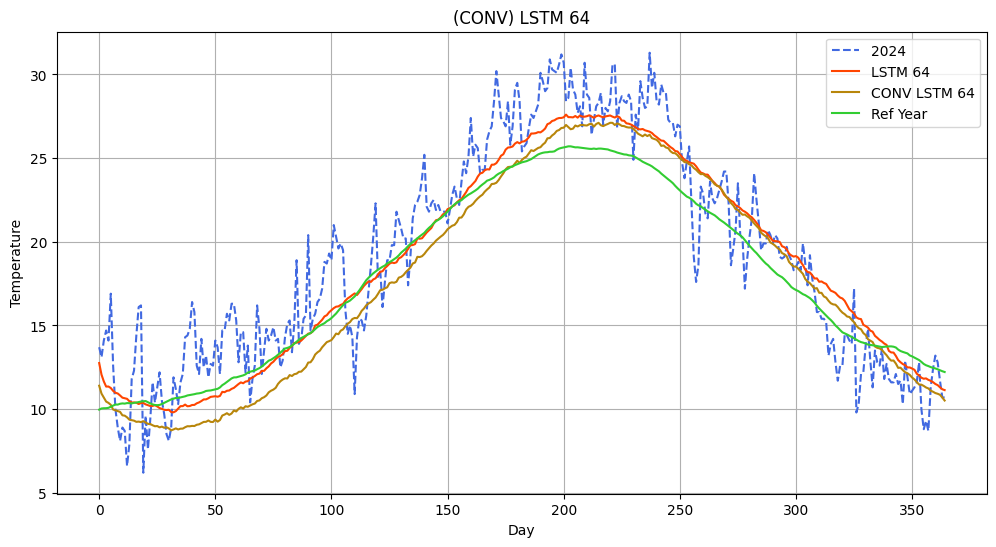

In [10]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_64[:, 2], label="LSTM 64", color='orangered')
plt.plot(x, Y_conv_lstm_64[:, 2], label="CONV LSTM 64", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [42]:
lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_128 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_128.save('models/lstm_128.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 221.8504 - mae: 12.7131 - val_loss: 48.7851 - val_mae: 5.8103
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 44.0558 - mae: 5.6086 - val_loss: 43.3969 - val_mae: 5.6402
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 42.2680 - mae: 5.5446 - val_loss: 43.3877 - val_mae: 5.6407
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 42.2972 - mae: 5.5468 - val_loss: 43.3740 - val_mae: 5.6404
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 42.2860 - mae: 5.5462 - val_loss: 43.4092 - val_mae: 5.6417
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 42.2819 - mae: 5.5461 - val_loss: 43.3973 - val_mae: 5.6413
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 42.2983 - mae: 5.5466 - val_loss: 43.4361 - val_mae: 5.6429
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 42.2659 - mae: 5.5443 - val_loss: 43.4475 - val_mae: 5.6432
Epoch 9/60
183/183 ━━━━━━━━━━━

In [43]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_2 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_128.save('models/lstm_128.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 26.2016 - mae: 4.1506 - val_loss: 28.9109 - val_mae: 4.3734
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 24.6444 - mae: 4.0194 - val_loss: 34.9358 - val_mae: 4.6738
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 28.3810 - mae: 4.3150 - val_loss: 26.1944 - val_mae: 4.1811
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 26.1284 - mae: 4.1445 - val_loss: 26.1389 - val_mae: 4.1651
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 25.8013 - mae: 4.1092 - val_loss: 26.2618 - val_mae: 4.1636
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 25.7081 - mae: 4.0954 - val_loss: 26.7606 - val_mae: 4.1826
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 25.4922 - mae: 4.0702 - val_loss: 27.3499 - val_mae: 4.1936
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 25.4797 - mae: 4.0661 - val_loss: 25.8384 - val_mae: 4.0871
Epoch 9/20
183/183 ━━━━━━━━━━━━━

In [44]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_3 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_128.save('models/lstm_128.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 25.3337 - mae: 4.0616 - val_loss: 25.5767 - val_mae: 4.1030
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 24.7929 - mae: 4.0030 - val_loss: 25.6382 - val_mae: 4.1207
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 25.3068 - mae: 4.0462 - val_loss: 26.6135 - val_mae: 4.1836
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 25.8785 - mae: 4.1055 - val_loss: 26.3241 - val_mae: 4.1551
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 25.4364 - mae: 4.0627 - val_loss: 25.8241 - val_mae: 4.0937
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 25.2113 - mae: 4.0447 - val_loss: 28.5781 - val_mae: 4.3543
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 26.5574 - mae: 4.1719 - val_loss: 23.3667 - val_mae: 3.9398
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 23.1463 - mae: 3.8639 - val_loss: 20.6388 - val_mae: 3.6993
Epoch 9/20
183/183 ━━━━━━━━━━━━━

In [46]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_4 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_128.save('models/lstm_128.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 25.7247 - mae: 4.1003 - val_loss: 26.7932 - val_mae: 4.1771
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 25.5663 - mae: 4.0734 - val_loss: 26.7216 - val_mae: 4.1523
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 25.1662 - mae: 4.0361 - val_loss: 28.2930 - val_mae: 4.1915
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 26.6593 - mae: 4.1146 - val_loss: 23.4133 - val_mae: 3.8549
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 28.0886 - mae: 4.2810 - val_loss: 28.0708 - val_mae: 4.3549
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 27.1741 - mae: 4.2436 - val_loss: 27.0681 - val_mae: 4.2358
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 26.2197 - mae: 4.1370 - val_loss: 26.8209 - val_mae: 4.1951
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 26.1146 - mae: 4.1232 - val_loss: 26.6406 - val_mae: 4.1870
Epoch 9/20
183/183 ━━━━━━━━━━━━━

In [48]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_5 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_128.save('models/lstm_128.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 25.2581 - mae: 4.0544 - val_loss: 26.2145 - val_mae: 4.1487
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 25.1322 - mae: 4.0420 - val_loss: 26.2936 - val_mae: 4.1471
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 25.2208 - mae: 4.0484 - val_loss: 26.2564 - val_mae: 4.1449
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 24.8676 - mae: 4.0150 - val_loss: 25.0413 - val_mae: 4.0727
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 24.4591 - mae: 3.9715 - val_loss: 18.5557 - val_mae: 3.4810
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 15.7783 - mae: 3.1412 - val_loss: 9.0176 - val_mae: 2.3829
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 9.3306 - mae: 2.3746 - val_loss: 8.1268 - val_mae: 2.2545
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 8.6713 - mae: 2.2763 - val_loss: 10.6892 - val_mae: 2.6071
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━

In [49]:
lstm_128 = tf.keras.models.load_model('models/lstm_128.keras')

Y_lstm_128 = lstm_128.predict(X)  # shape: (1, 365, 3)
Y_lstm_128 = Y_lstm_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_128_pred.csv')

mae_lstm_128 = mean_absolute_error(Y_test[:, 2], Y_lstm_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_128:.3f}')

rmse_lstm_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Mean Absolute Error (MAE): 2.016
Root Mean Squared Error (RMSE): 2.505


In [50]:
conv_lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_128 = conv_lstm_128.fit(train_ds, validation_data=valid_ds, epochs=80)
conv_lstm_128.save('models/conv_lstm_128.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 222.9968 - mae: 12.7777 - val_loss: 50.2391 - val_mae: 5.8627
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 44.6416 - mae: 5.6299 - val_loss: 43.4206 - val_mae: 5.6406
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 41.8670 - mae: 5.5165 - val_loss: 42.0510 - val_mae: 5.5491
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 40.7697 - mae: 5.4389 - val_loss: 41.2742 - val_mae: 5.4952
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 40.0563 - mae: 5.3875 - val_loss: 40.6739 - val_mae: 5.4525
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 39.5339 - mae: 5.3498 - val_loss: 39.9423 - val_mae: 5.4004
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 38.7447 - mae: 5.2917 - val_loss: 38.7715 - val_mae: 5.3168
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 37.6418 - mae: 5.2076 - val_loss: 37.6872 - val_mae: 5.2353
Epoch 9/80
183/183 ━━━━━━━━━━━

In [51]:
conv_lstm_128 = tf.keras.models.load_model('models/conv_lstm_128.keras')

Y_conv_lstm_128 = conv_lstm_128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_128 = Y_conv_lstm_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_128_pred.csv')

mae_conv_lstm_128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_128:.3f}')

rmse_conv_lstm_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Mean Absolute Error (MAE): 2.005
Root Mean Squared Error (RMSE): 2.504


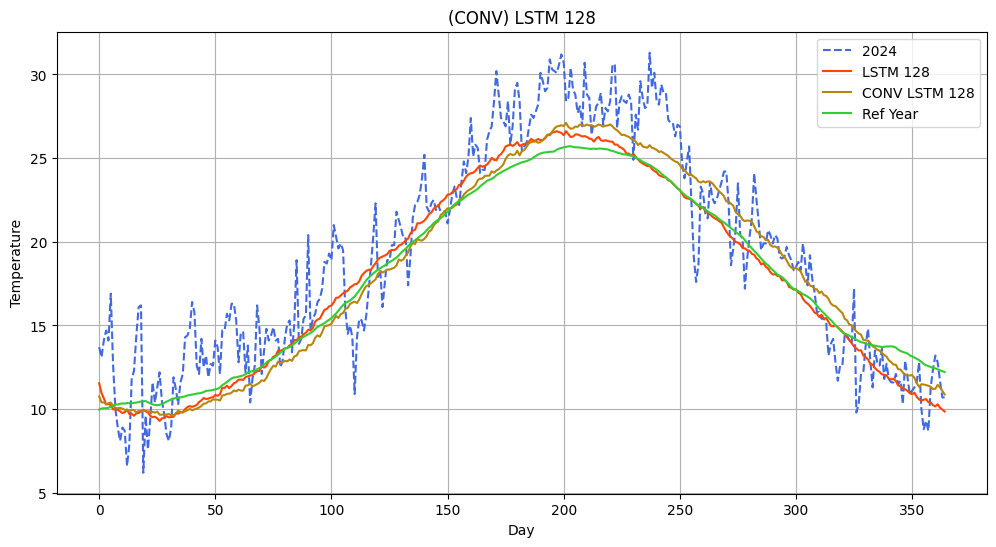

In [52]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_128[:, 2], label="LSTM 128", color='orangered')
plt.plot(x, Y_conv_lstm_128[:, 2], label="CONV LSTM 128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_3232 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 313.3713 - mae: 16.0611 - val_loss: 185.5240 - val_mae: 11.6713
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 150.9425 - mae: 10.3439 - val_loss: 100.2113 - val_mae: 8.0782
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 83.6334 - mae: 7.3924 - val_loss: 63.9972 - val_mae: 6.4271
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 56.1992 - mae: 6.1175 - val_loss: 50.1043 - val_mae: 5.8575
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 46.3655 - mae: 5.6958 - val_loss: 45.3467 - val_mae: 5.6960
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 43.2533 - mae: 5.5766 - val_loss: 43.8956 - val_mae: 5.6520
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 42.4112 - mae: 5.5458 - val_loss: 43.4928 - val_mae: 5.6414
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 42.2425 - mae: 5.5418 - val_loss: 43.3834 - val_mae: 5.6396
Epoch 9/60
183/183 ━━━━

In [8]:
from tensorflow.keras.models import load_model
lstm_3232 = load_model('models/lstm_3232.keras')
history_lstm_3232_2 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=40)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 42.2536 - mae: 5.5440 - val_loss: 43.3797 - val_mae: 5.6401
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 42.2262 - mae: 5.5422 - val_loss: 43.4038 - val_mae: 5.6400
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 42.2489 - mae: 5.5431 - val_loss: 43.0626 - val_mae: 5.6114
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 40.8879 - mae: 5.4422 - val_loss: 38.1028 - val_mae: 5.2633
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 36.3449 - mae: 5.1098 - val_loss: 35.0865 - val_mae: 5.0373
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 33.8027 - mae: 4.9082 - val_loss: 33.1285 - val_mae: 4.8805
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 32.0178 - mae: 4.7613 - val_loss: 31.5475 - val_mae: 4.7543
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 30.5794 - mae: 4.6368 - val_loss: 30.2946 - val_mae: 4.6381
Epoch 9/40
183/183 ━━━━━━━━━

In [9]:
lstm_3232 = tf.keras.models.load_model('models/lstm_3232.keras')

Y_lstm_3232 = lstm_3232.predict(X)  # shape: (1, 365, 3)
Y_lstm_3232 = Y_lstm_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_3232_pred.csv')

mae_lstm_3232 = mean_absolute_error(Y_test[:, 2], Y_lstm_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_3232:.3f}')

rmse_lstm_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Mean Absolute Error (MAE): 2.199
Root Mean Squared Error (RMSE): 2.724


In [10]:
conv_lstm_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_3232.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_3232 = conv_lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_3232.save('models/conv_lstm_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 313.9505 - mae: 16.0835 - val_loss: 189.3752 - val_mae: 11.8211
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 154.4776 - mae: 10.4894 - val_loss: 102.7736 - val_mae: 8.1939
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 85.6668 - mae: 7.4878 - val_loss: 65.3016 - val_mae: 6.4853
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 57.2103 - mae: 6.1645 - val_loss: 50.6623 - val_mae: 5.8780
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 46.7540 - mae: 5.7116 - val_loss: 45.5521 - val_mae: 5.7023
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 43.3810 - mae: 5.5810 - val_loss: 43.9632 - val_mae: 5.6540
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.4761 - mae: 5.5487 - val_loss: 43.5093 - val_mae: 5.6417
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 42.2443 - mae: 5.5411 - val_loss: 43.3895 - val_mae: 5.6397
Epoch 9/60
183/183 ━━━━━━

In [11]:
from tensorflow.keras.models import load_model
conv_lstm_3232 = load_model('models/conv_lstm_3232.keras')
history_conv_lstm_3232_2 = conv_lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=20)
conv_lstm_3232.save('models/conv_lstm_3232.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 23.6077 - mae: 4.0312 - val_loss: 21.6323 - val_mae: 3.8522
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 19.9594 - mae: 3.6723 - val_loss: 17.9404 - val_mae: 3.4751
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 16.1186 - mae: 3.2584 - val_loss: 14.0425 - val_mae: 3.0348
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 13.0734 - mae: 2.8957 - val_loss: 11.7327 - val_mae: 2.7432
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.2083 - mae: 2.6572 - val_loss: 10.2758 - val_mae: 2.5462
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 9.8065 - mae: 2.4628 - val_loss: 9.3208 - val_mae: 2.4119
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.8640 - mae: 2.3220 - val_loss: 8.4254 - val_mae: 2.2840
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.2139 - mae: 2.2224 - val_loss: 8.0002 - val_mae: 2.2231
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━

In [12]:
conv_lstm_3232 = tf.keras.models.load_model('models/conv_lstm_3232.keras')

Y_conv_lstm_3232 = conv_lstm_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_3232 = Y_conv_lstm_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_3232_pred.csv')

mae_conv_lstm_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_3232:.3f}')

rmse_conv_lstm_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
Mean Absolute Error (MAE): 2.182
Root Mean Squared Error (RMSE): 2.682


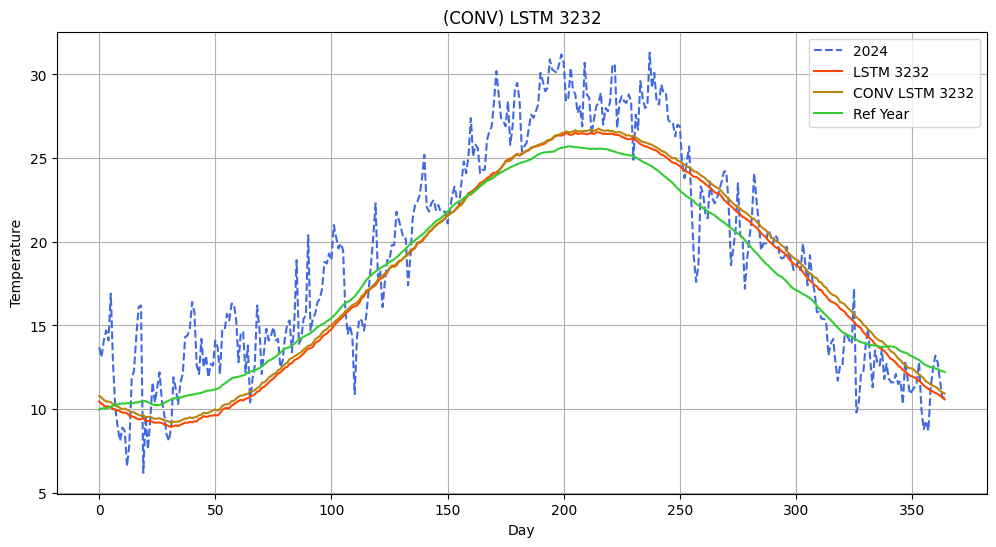

In [13]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_3232[:, 2], label="LSTM 3232", color='orangered')
plt.plot(x, Y_conv_lstm_3232[:, 2], label="CONV LSTM 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [14]:
lstm_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_6464 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 274.1464 - mae: 14.7074 - val_loss: 100.7863 - val_mae: 8.1038
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 76.5692 - mae: 7.0624 - val_loss: 50.2841 - val_mae: 5.8643
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 45.6666 - mae: 5.6693 - val_loss: 43.9711 - val_mae: 5.6543
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 42.4182 - mae: 5.5477 - val_loss: 43.4029 - val_mae: 5.6399
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 42.2409 - mae: 5.5424 - val_loss: 43.3569 - val_mae: 5.6396
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 42.2428 - mae: 5.5434 - val_loss: 43.3561 - val_mae: 5.6397
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 42.2050 - mae: 5.5412 - val_loss: 43.3606 - val_mae: 5.6399
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 42.1981 - mae: 5.5400 - val_loss: 43.3619 - val_mae: 5.6399
Epoch 9/60
183/183 ━━━━━━━

In [15]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_2 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 10.3261 - mae: 2.5282 - val_loss: 9.2807 - val_mae: 2.4146
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 9.3482 - mae: 2.3877 - val_loss: 8.2747 - val_mae: 2.2661
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 8.8796 - mae: 2.3169 - val_loss: 7.7859 - val_mae: 2.1893
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 8.3963 - mae: 2.2436 - val_loss: 7.7810 - val_mae: 2.1887
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 8.1517 - mae: 2.2065 - val_loss: 7.9712 - val_mae: 2.2055
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 8.3027 - mae: 2.2237 - val_loss: 7.8822 - val_mae: 2.1976
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 7.9245 - mae: 2.1703 - val_loss: 7.1466 - val_mae: 2.0929
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 7.7381 - mae: 2.1422 - val_loss: 7.3374 - val_mae: 2.1181
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 4

In [17]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_3 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 7.1705 - mae: 2.0530 - val_loss: 6.9596 - val_mae: 2.0547
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 7.1629 - mae: 2.0520 - val_loss: 6.8819 - val_mae: 2.0408
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 7.1756 - mae: 2.0529 - val_loss: 6.9808 - val_mae: 2.0572
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 7.0090 - mae: 2.0271 - val_loss: 6.7936 - val_mae: 2.0323
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 7.0306 - mae: 2.0304 - val_loss: 7.8664 - val_mae: 2.1922
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 7.0663 - mae: 2.0369 - val_loss: 6.7666 - val_mae: 2.0250
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 6.9993 - mae: 2.0249 - val_loss: 7.1864 - val_mae: 2.0941
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 6.9342 - mae: 2.0146 - val_loss: 7.1644 - val_mae: 2.0909
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 5

In [19]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_4 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 6.9592 - mae: 2.0178 - val_loss: 7.0433 - val_mae: 2.0721
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 6.8953 - mae: 2.0080 - val_loss: 7.0957 - val_mae: 2.0759
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 6.8760 - mae: 2.0048 - val_loss: 6.6404 - val_mae: 2.0068
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 6.9074 - mae: 2.0098 - val_loss: 7.0519 - val_mae: 2.0786
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 6.8451 - mae: 1.9994 - val_loss: 6.9306 - val_mae: 2.0544
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 6.8233 - mae: 1.9955 - val_loss: 6.9382 - val_mae: 2.0611
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 6.8250 - mae: 1.9965 - val_loss: 7.0969 - val_mae: 2.0749
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 6.8198 - mae: 1.9952 - val_loss: 7.1352 - val_mae: 2.0934
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 39

In [21]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_5 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 6.7465 - mae: 1.9831 - val_loss: 7.0139 - val_mae: 2.0762
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 6.7384 - mae: 1.9820 - val_loss: 7.0653 - val_mae: 2.0821
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 6.7487 - mae: 1.9840 - val_loss: 6.8260 - val_mae: 2.0469
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 6.7402 - mae: 1.9830 - val_loss: 6.9613 - val_mae: 2.0791
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 6.6748 - mae: 1.9727 - val_loss: 6.8642 - val_mae: 2.0604
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 6.7632 - mae: 1.9871 - val_loss: 6.7006 - val_mae: 2.0288
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 6.6513 - mae: 1.9684 - val_loss: 6.8154 - val_mae: 2.0510
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 6.6090 - mae: 1.9617 - val_loss: 7.2383 - val_mae: 2.1248
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51

In [23]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_6 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 6.5535 - mae: 1.9521 - val_loss: 6.9578 - val_mae: 2.0798
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 6.5358 - mae: 1.9489 - val_loss: 6.9384 - val_mae: 2.0772
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 6.5293 - mae: 1.9475 - val_loss: 6.9212 - val_mae: 2.0712
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 6.5272 - mae: 1.9475 - val_loss: 6.8168 - val_mae: 2.0553
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 6.5115 - mae: 1.9446 - val_loss: 6.6426 - val_mae: 2.0233
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 6.4927 - mae: 1.9421 - val_loss: 6.6894 - val_mae: 2.0342
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 6.4739 - mae: 1.9383 - val_loss: 6.6219 - val_mae: 2.0203
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 6.4699 - mae: 1.9382 - val_loss: 6.5948 - val_mae: 2.0139
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 

In [15]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_7 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 6.4250 - mae: 1.9304 - val_loss: 6.7720 - val_mae: 2.0452
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 6.4280 - mae: 1.9312 - val_loss: 6.8547 - val_mae: 2.0627
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 6.4134 - mae: 1.9288 - val_loss: 6.5687 - val_mae: 2.0105
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 6.4072 - mae: 1.9281 - val_loss: 6.7935 - val_mae: 2.0507
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 6.4005 - mae: 1.9263 - val_loss: 6.7078 - val_mae: 2.0371
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 6.3856 - mae: 1.9239 - val_loss: 6.6457 - val_mae: 2.0234
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 6.3887 - mae: 1.9247 - val_loss: 6.7789 - val_mae: 2.0481
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 6.3778 - mae: 1.9229 - val_loss: 6.8526 - val_mae: 2.0623
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s

In [16]:
lstm_6464 = tf.keras.models.load_model('models/lstm_6464.keras')

Y_lstm_6464 = lstm_6464.predict(X)  # shape: (1, 365, 3)
Y_lstm_6464 = Y_lstm_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_6464_pred.csv')

mae_lstm_6464 = mean_absolute_error(Y_test[:, 2], Y_lstm_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_6464:.3f}')

rmse_lstm_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Mean Absolute Error (MAE): 2.522
Root Mean Squared Error (RMSE): 3.080


In [25]:
conv_lstm_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_6464.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_6464 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 274.7936 - mae: 14.7362 - val_loss: 103.0313 - val_mae: 8.2053
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 78.1320 - mae: 7.1364 - val_loss: 50.7941 - val_mae: 5.8830
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 45.9368 - mae: 5.6802 - val_loss: 44.0458 - val_mae: 5.6565
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 42.4771 - mae: 5.5507 - val_loss: 43.4105 - val_mae: 5.6400
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 42.2164 - mae: 5.5411 - val_loss: 43.3550 - val_mae: 5.6395
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 42.2267 - mae: 5.5422 - val_loss: 43.3532 - val_mae: 5.6397
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 42.2121 - mae: 5.5417 - val_loss: 43.3537 - val_mae: 5.6397
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 42.2348 - mae: 5.5427 - val_loss: 43.3638 - val_mae: 5.6400
Epoch 9/60
183/183 ━━━━━━━━━━

In [27]:
from tensorflow.keras.models import load_model
conv_lstm_6464 = load_model('models/conv_lstm_6464.keras')
history_conv_lstm_6464_2 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 6.6803 - mae: 1.9728 - val_loss: 6.1727 - val_mae: 1.9313
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 6.6405 - mae: 1.9657 - val_loss: 6.2748 - val_mae: 1.9489
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.6323 - mae: 1.9645 - val_loss: 6.1106 - val_mae: 1.9231
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.6074 - mae: 1.9608 - val_loss: 6.3229 - val_mae: 1.9598
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.6110 - mae: 1.9605 - val_loss: 6.0660 - val_mae: 1.9141
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.5836 - mae: 1.9564 - val_loss: 6.1235 - val_mae: 1.9258
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.5741 - mae: 1.9543 - val_loss: 6.3190 - val_mae: 1.9629
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.5796 - mae: 1.9551 - val_loss: 6.0610 - val_mae: 1.9135
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/

In [17]:
from tensorflow.keras.models import load_model
conv_lstm_6464 = load_model('models/conv_lstm_6464.keras')
history_conv_lstm_6464_3 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 6.5433 - mae: 1.9490 - val_loss: 6.0290 - val_mae: 1.9045
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 6.5395 - mae: 1.9482 - val_loss: 6.0566 - val_mae: 1.9050
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 6.5657 - mae: 1.9529 - val_loss: 6.0598 - val_mae: 1.9114
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.5308 - mae: 1.9467 - val_loss: 6.1986 - val_mae: 1.9350
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 6.5366 - mae: 1.9474 - val_loss: 6.2876 - val_mae: 1.9565
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.5217 - mae: 1.9448 - val_loss: 6.1065 - val_mae: 1.9165
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 6.5133 - mae: 1.9431 - val_loss: 6.2720 - val_mae: 1.9504
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.5104 - mae: 1.9427 - val_loss: 6.0486 - val_mae: 1.9073
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/

In [18]:
conv_lstm_6464 = tf.keras.models.load_model('models/conv_lstm_6464.keras')

Y_conv_lstm_6464 = conv_lstm_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_6464 = Y_conv_lstm_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_6464_pred.csv')

mae_conv_lstm_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_6464:.3f}')

rmse_conv_lstm_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Mean Absolute Error (MAE): 2.283
Root Mean Squared Error (RMSE): 2.773


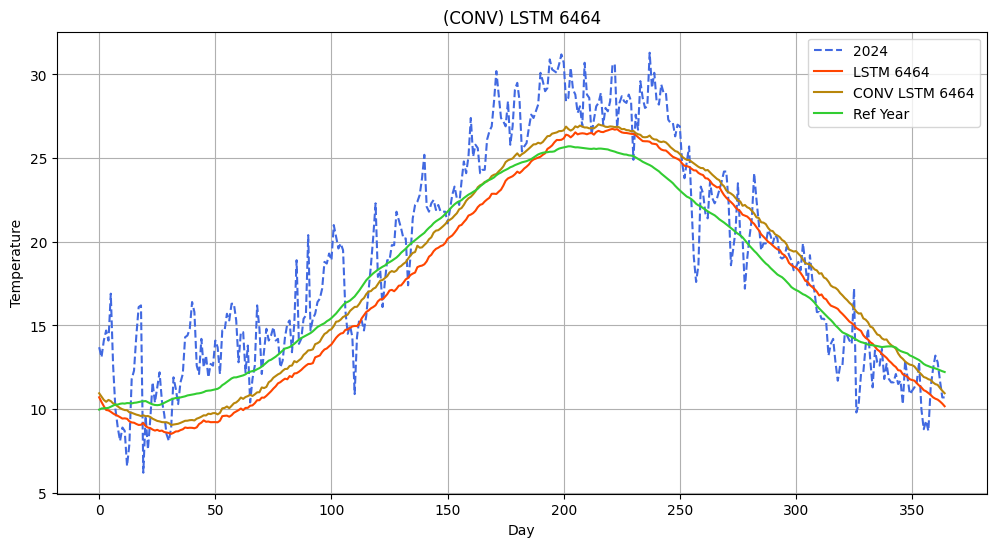

In [19]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_6464[:, 2], label="LSTM 6464", color='orangered')
plt.plot(x, Y_conv_lstm_6464[:, 2], label="CONV LSTM 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [30]:
lstm_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_128128 = lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
lstm_128128.save('models/lstm_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 221.0763 - mae: 12.6984 - val_loss: 49.4086 - val_mae: 5.8327
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 44.2724 - mae: 5.6161 - val_loss: 43.4044 - val_mae: 5.6402
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 42.2137 - mae: 5.5409 - val_loss: 43.3782 - val_mae: 5.6405
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 42.2533 - mae: 5.5435 - val_loss: 43.3898 - val_mae: 5.6407
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 42.2468 - mae: 5.5429 - val_loss: 43.3983 - val_mae: 5.6413
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 42.2488 - mae: 5.5437 - val_loss: 43.4222 - val_mae: 5.6422
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 42.3099 - mae: 5.5474 - val_loss: 43.4245 - val_mae: 5.6424
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 42.2978 - mae: 5.5469 - val_loss: 43.4360 - val_mae: 5.6429
Epoch 9/40
183/183 ━━━━━━━━━━━

In [31]:
from tensorflow.keras.models import load_model
lstm_128128 = load_model('models/lstm_128128.keras')
history_lstm_128128_2 = lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128128.save('models/lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 8.3181 - mae: 2.2322 - val_loss: 7.6021 - val_mae: 2.1630
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 7.6254 - mae: 2.1254 - val_loss: 6.8251 - val_mae: 2.0423
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 7.4276 - mae: 2.0948 - val_loss: 7.3167 - val_mae: 2.1171
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 7.2686 - mae: 2.0693 - val_loss: 6.9827 - val_mae: 2.0733
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 7.2090 - mae: 2.0609 - val_loss: 6.9012 - val_mae: 2.0628
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 7.0888 - mae: 2.0404 - val_loss: 6.5020 - val_mae: 1.9915
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 7.0903 - mae: 2.0404 - val_loss: 7.0448 - val_mae: 2.0898
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 7.0598 - mae: 2.0355 - val_loss: 6.9606 - val_mae: 2.0644
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms

In [33]:
from tensorflow.keras.models import load_model
lstm_128128 = load_model('models/lstm_128128.keras')
history_lstm_128128_3 = lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128128.save('models/lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 6.8884 - mae: 2.0073 - val_loss: 6.4270 - val_mae: 1.9781
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 6.8725 - mae: 2.0044 - val_loss: 6.5280 - val_mae: 1.9999
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 6.8287 - mae: 1.9978 - val_loss: 6.4058 - val_mae: 1.9744
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 6.7964 - mae: 1.9918 - val_loss: 6.4036 - val_mae: 1.9700
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 6.7821 - mae: 1.9899 - val_loss: 6.3988 - val_mae: 1.9738
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 6.7391 - mae: 1.9823 - val_loss: 6.2927 - val_mae: 1.9531
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 6.7058 - mae: 1.9765 - val_loss: 6.1453 - val_mae: 1.9185
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 6.6651 - mae: 1.9697 - val_loss: 6.0901 - val_mae: 1.9095
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms

In [34]:
lstm_128128 = tf.keras.models.load_model('models/lstm_128128.keras')

Y_lstm_128128 = lstm_128128.predict(X)  # shape: (1, 365, 3)
Y_lstm_128128 = Y_lstm_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_128128_pred.csv')

mae_lstm_128128 = mean_absolute_error(Y_test[:, 2], Y_lstm_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_128128:.3f}')

rmse_lstm_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Mean Absolute Error (MAE): 2.200
Root Mean Squared Error (RMSE): 2.727


In [35]:
conv_lstm_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_128128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_128128 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 222.6146 - mae: 12.7575 - val_loss: 49.7893 - val_mae: 5.8465
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 44.4654 - mae: 5.6238 - val_loss: 43.4121 - val_mae: 5.6404
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 42.2611 - mae: 5.5443 - val_loss: 43.3686 - val_mae: 5.6400
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 42.2432 - mae: 5.5429 - val_loss: 43.3986 - val_mae: 5.6416
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 42.2702 - mae: 5.5451 - val_loss: 43.3987 - val_mae: 5.6412
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 42.2360 - mae: 5.5427 - val_loss: 43.3980 - val_mae: 5.6410
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 42.3052 - mae: 5.5476 - val_loss: 43.4154 - val_mae: 5.6419
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 42.3236 - mae: 5.5490 - val_loss: 43.4436 - val_mae: 5.6431
Epoch 9/40
183/183 ━━━━━━━━━━━

In [37]:
from tensorflow.keras.models import load_model
conv_lstm_128128 = load_model('models/conv_lstm_128128.keras')
history_conv_lstm_128128_2 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 6.5920 - mae: 1.9582 - val_loss: 6.3119 - val_mae: 1.9465
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 6.5444 - mae: 1.9491 - val_loss: 6.4712 - val_mae: 1.9818
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.5304 - mae: 1.9472 - val_loss: 6.4763 - val_mae: 1.9842
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.4794 - mae: 1.9381 - val_loss: 6.5085 - val_mae: 1.9899
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.4428 - mae: 1.9326 - val_loss: 6.4898 - val_mae: 1.9840
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.4074 - mae: 1.9265 - val_loss: 6.5216 - val_mae: 1.9909
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.3787 - mae: 1.9229 - val_loss: 6.6037 - val_mae: 2.0048
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.3792 - mae: 1.9223 - val_loss: 6.5347 - val_mae: 1.9956
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/

In [39]:
from tensorflow.keras.models import load_model
conv_lstm_128128 = load_model('models/conv_lstm_128128.keras')
history_conv_lstm_128128_3 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 6.3217 - mae: 1.9132 - val_loss: 6.8149 - val_mae: 2.0465
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.3012 - mae: 1.9098 - val_loss: 6.8182 - val_mae: 2.0453
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 6.3157 - mae: 1.9125 - val_loss: 6.9305 - val_mae: 2.0602
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 6.2924 - mae: 1.9086 - val_loss: 6.6852 - val_mae: 2.0200
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.2769 - mae: 1.9055 - val_loss: 6.7747 - val_mae: 2.0378
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 6.2577 - mae: 1.9025 - val_loss: 6.7184 - val_mae: 2.0242
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 6.2351 - mae: 1.8984 - val_loss: 6.8476 - val_mae: 2.0520
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 6.2261 - mae: 1.8973 - val_loss: 6.7208 - val_mae: 2.0216
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/

In [40]:
conv_lstm_128128 = tf.keras.models.load_model('models/conv_lstm_128128.keras')

Y_conv_lstm_128128 = conv_lstm_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_128128 = Y_conv_lstm_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_128128_pred.csv')

mae_conv_lstm_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_128128:.3f}')

rmse_conv_lstm_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Mean Absolute Error (MAE): 2.293
Root Mean Squared Error (RMSE): 2.777


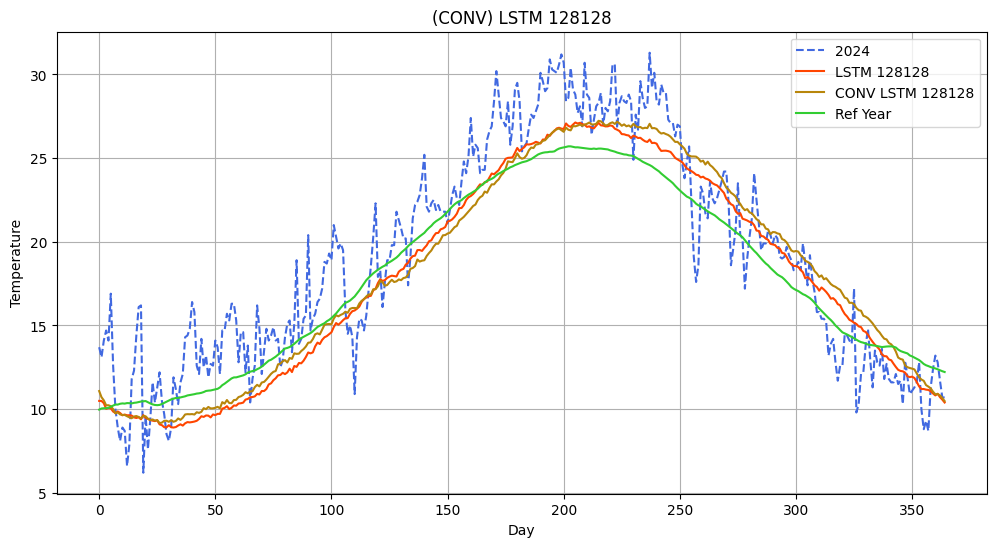

In [41]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_128128[:, 2], label="LSTM 128128", color='orangered')
plt.plot(x, Y_conv_lstm_128128[:, 2], label="CONV LSTM 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [42]:
gru_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_32.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_32 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=80)
gru_32.save('models/gru_32.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 314.5117 - mae: 16.1157 - val_loss: 203.3432 - val_mae: 12.3559
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 167.4471 - mae: 11.0173 - val_loss: 113.1829 - val_mae: 8.6617
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 94.2870 - mae: 7.8875 - val_loss: 70.9502 - val_mae: 6.7398
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 61.5842 - mae: 6.3647 - val_loss: 53.2179 - val_mae: 5.9741
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 48.5107 - mae: 5.7822 - val_loss: 46.5510 - val_mae: 5.7334
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 44.0298 - mae: 5.6052 - val_loss: 44.3048 - val_mae: 5.6644
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 42.6461 - mae: 5.5544 - val_loss: 43.6212 - val_mae: 5.6444
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 42.3189 - mae: 5.5448 - val_loss: 43.4232 - val_mae: 5.6402
Epoch 9/80
183/183 ━━━━━━

In [43]:
from tensorflow.keras.models import load_model
gru_32 = load_model('models/gru_32.keras')
history_gru_32_2 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=20)
gru_32.save('models/gru_32.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 25.1553 - mae: 4.0713 - val_loss: 25.2738 - val_mae: 4.1089
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 25.0758 - mae: 4.0645 - val_loss: 25.3477 - val_mae: 4.1141
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 25.1274 - mae: 4.0677 - val_loss: 25.2705 - val_mae: 4.1086
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 25.1092 - mae: 4.0640 - val_loss: 25.2008 - val_mae: 4.0998
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 24.9447 - mae: 4.0481 - val_loss: 25.2415 - val_mae: 4.1021
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 24.9926 - mae: 4.0520 - val_loss: 25.1693 - val_mae: 4.0954
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 25.0181 - mae: 4.0541 - val_loss: 25.1437 - val_mae: 4.0931
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 25.0122 - mae: 4.0535 - val_loss: 25.1505 - val_mae: 4.0933
Epoch 9/20
183/183 ━━━━━━━━━━━━━

In [44]:
from tensorflow.keras.models import load_model
gru_32 = load_model('models/gru_32.keras')
history_gru_32_3 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_32.save('models/gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 8.2850 - mae: 2.2263 - val_loss: 7.4380 - val_mae: 2.1350
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 7.9063 - mae: 2.1702 - val_loss: 7.4268 - val_mae: 2.1413
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 7.6614 - mae: 2.1329 - val_loss: 6.7754 - val_mae: 2.0299
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 7.4705 - mae: 2.1031 - val_loss: 6.8431 - val_mae: 2.0454
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 7.3295 - mae: 2.0795 - val_loss: 6.6470 - val_mae: 2.0107
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.2185 - mae: 2.0625 - val_loss: 6.5973 - val_mae: 2.0041
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 7.1635 - mae: 2.0538 - val_loss: 6.5453 - val_mae: 1.9953
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 7.1023 - mae: 2.0440 - val_loss: 6.6365 - val_mae: 2.0141
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/

In [46]:
from tensorflow.keras.models import load_model
gru_32 = load_model('models/gru_32.keras')
history_gru_32_4 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_32.save('models/gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 6.9736 - mae: 2.0225 - val_loss: 6.2610 - val_mae: 1.9432
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.9459 - mae: 2.0174 - val_loss: 6.4878 - val_mae: 1.9875
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 6.9326 - mae: 2.0165 - val_loss: 6.3347 - val_mae: 1.9570
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.9000 - mae: 2.0108 - val_loss: 6.3144 - val_mae: 1.9523
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.8671 - mae: 2.0053 - val_loss: 6.4245 - val_mae: 1.9715
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 6.8547 - mae: 2.0028 - val_loss: 6.0429 - val_mae: 1.9033
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 6.8501 - mae: 2.0030 - val_loss: 6.2079 - val_mae: 1.9340
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 6.8220 - mae: 1.9975 - val_loss: 6.1713 - val_mae: 1.9257
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/

In [47]:
gru_32 = tf.keras.models.load_model('models/gru_32.keras')

Y_gru_32 = gru_32.predict(X)  # shape: (1, 365, 3)
Y_gru_32 = Y_gru_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_32_pred.csv')

mae_gru_32 = mean_absolute_error(Y_test[:, 2], Y_gru_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_32:.3f}')

rmse_gru_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Mean Absolute Error (MAE): 2.316
Root Mean Squared Error (RMSE): 2.867


In [56]:
conv_gru_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_32.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_32 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=80)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 315.0247 - mae: 16.1287 - val_loss: 205.3634 - val_mae: 12.4286
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 169.4593 - mae: 11.0951 - val_loss: 114.7366 - val_mae: 8.7303
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 95.7273 - mae: 7.9517 - val_loss: 71.8343 - val_mae: 6.7802
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 62.2864 - mae: 6.3977 - val_loss: 53.6460 - val_mae: 5.9903
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 48.8488 - mae: 5.7972 - val_loss: 46.7296 - val_mae: 5.7391
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 44.1234 - mae: 5.6079 - val_loss: 44.3719 - val_mae: 5.6665
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 42.6786 - mae: 5.5551 - val_loss: 43.6419 - val_mae: 5.6450
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 42.3003 - mae: 5.5430 - val_loss: 43.4290 - val_mae: 5.6402
Epoch 9/80
183/183 ━━━━━━

In [20]:
from tensorflow.keras.models import load_model
conv_gru_32 = load_model('models/conv_gru_32.keras')
history_conv_gru_32_2 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 6.5108 - mae: 1.9435 - val_loss: 5.9739 - val_mae: 1.8898
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 6.4916 - mae: 1.9412 - val_loss: 6.0664 - val_mae: 1.9065
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.5163 - mae: 1.9449 - val_loss: 5.9315 - val_mae: 1.8839
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4873 - mae: 1.9401 - val_loss: 5.9107 - val_mae: 1.8806
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.4796 - mae: 1.9391 - val_loss: 5.9672 - val_mae: 1.8903
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.4693 - mae: 1.9374 - val_loss: 5.9422 - val_mae: 1.8842
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.4638 - mae: 1.9363 - val_loss: 5.8888 - val_mae: 1.8753
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.4658 - mae: 1.9367 - val_loss: 6.0988 - val_mae: 1.9159
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/s

In [21]:
conv_gru_32 = tf.keras.models.load_model('models/conv_gru_32.keras')

Y_conv_gru_32 = conv_gru_32.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_32 = Y_conv_gru_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_32_pred.csv')

mae_conv_gru_32 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_32:.3f}')

rmse_conv_gru_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Mean Absolute Error (MAE): 2.243
Root Mean Squared Error (RMSE): 2.773


In [22]:
gru_32 = tf.keras.models.load_model('models/gru_32.keras')

Y_gru_32 = gru_32.predict(X)  # shape: (1, 365, 3)
Y_gru_32 = Y_gru_32[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ -2s -2423206us/step


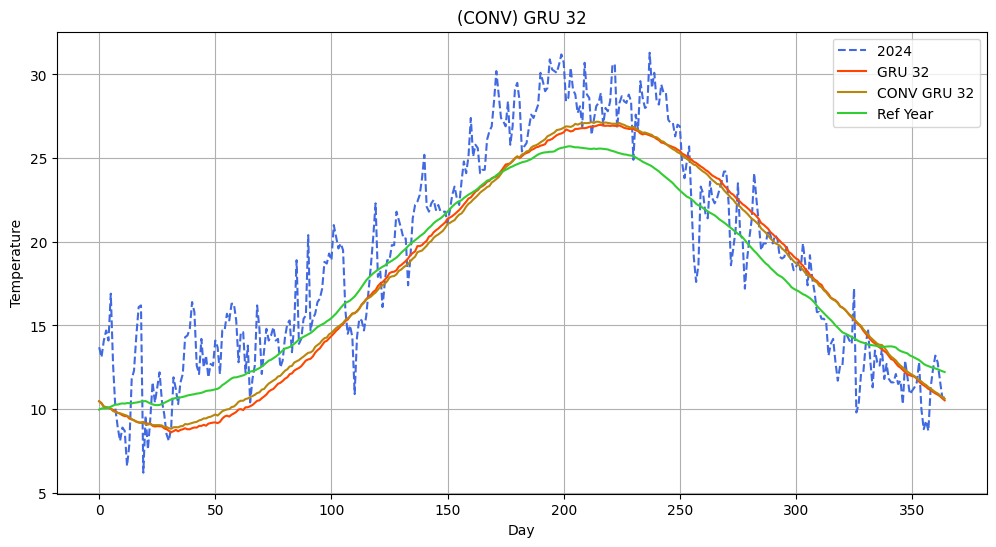

In [23]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_32[:, 2], label="GRU 32", color='orangered')
plt.plot(x, Y_conv_gru_32[:, 2], label="CONV GRU 32", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [59]:
gru_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_64.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_64 = gru_64.fit(train_ds, validation_data=valid_ds, epochs=60)
gru_64.save('models/gru_64.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 276.6694 - mae: 14.8213 - val_loss: 111.9924 - val_mae: 8.6073
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 84.8518 - mae: 7.4456 - val_loss: 53.1860 - val_mae: 5.9729
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 47.3455 - mae: 5.7363 - val_loss: 44.3989 - val_mae: 5.6673
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 42.5905 - mae: 5.5524 - val_loss: 43.4492 - val_mae: 5.6406
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 42.2298 - mae: 5.5412 - val_loss: 43.3622 - val_mae: 5.6396
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 42.2393 - mae: 5.5440 - val_loss: 43.3525 - val_mae: 5.6396
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 42.2027 - mae: 5.5407 - val_loss: 43.3653 - val_mae: 5.6401
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 42.2440 - mae: 5.5434 - val_loss: 43.3549 - val_mae: 5.6397
Epoch 9/60
183/183 ━━━━━━━━━━

In [61]:
from tensorflow.keras.models import load_model
gru_64 = load_model('models/gru_64.keras')
history_gru_64_2 = gru_64.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_64.save('models/gru_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 6.7657 - mae: 1.9888 - val_loss: 6.8163 - val_mae: 2.0397
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.7857 - mae: 1.9924 - val_loss: 6.5675 - val_mae: 1.9953
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.7322 - mae: 1.9834 - val_loss: 6.9408 - val_mae: 2.0607
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.7277 - mae: 1.9824 - val_loss: 6.6703 - val_mae: 2.0098
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.7278 - mae: 1.9822 - val_loss: 6.4323 - val_mae: 1.9767
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.6892 - mae: 1.9760 - val_loss: 6.6328 - val_mae: 2.0101
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.6761 - mae: 1.9735 - val_loss: 6.9190 - val_mae: 2.0558
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.6950 - mae: 1.9766 - val_loss: 6.8404 - val_mae: 2.0410
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/

In [62]:
gru_64 = tf.keras.models.load_model('models/gru_64.keras')

Y_gru_64 = gru_64.predict(X)  # shape: (1, 365, 3)
Y_gru_64 = Y_gru_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_64_pred.csv')

mae_gru_64 = mean_absolute_error(Y_test[:, 2], Y_gru_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_64:.3f}')

rmse_gru_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Mean Absolute Error (MAE): 2.069
Root Mean Squared Error (RMSE): 2.604


In [63]:
conv_gru_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_64.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_64 = conv_gru_64.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_64.save('models/conv_gru_64.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 277.2504 - mae: 14.8501 - val_loss: 114.6983 - val_mae: 8.7285
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 86.8023 - mae: 7.5368 - val_loss: 53.9299 - val_mae: 6.0014
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 47.8114 - mae: 5.7562 - val_loss: 44.5172 - val_mae: 5.6708
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 42.6593 - mae: 5.5552 - val_loss: 43.4645 - val_mae: 5.6409
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 42.2056 - mae: 5.5398 - val_loss: 43.3626 - val_mae: 5.6396
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 42.2184 - mae: 5.5413 - val_loss: 43.4908 - val_mae: 5.6419
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 42.2241 - mae: 5.5422 - val_loss: 43.4189 - val_mae: 5.6410
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 42.1847 - mae: 5.5396 - val_loss: 43.3681 - val_mae: 5.6400
Epoch 9/40
183/183 ━━━━━━━━━━━

In [65]:
from tensorflow.keras.models import load_model
conv_gru_64 = load_model('models/conv_gru_64.keras')
history_conv_gru_64_2 = conv_gru_64.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_64.save('models/conv_gru_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 6.4724 - mae: 1.9384 - val_loss: 6.3952 - val_mae: 1.9721
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.4696 - mae: 1.9382 - val_loss: 6.4582 - val_mae: 1.9806
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.4347 - mae: 1.9322 - val_loss: 6.5373 - val_mae: 1.9958
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.4153 - mae: 1.9293 - val_loss: 6.2678 - val_mae: 1.9475
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.4127 - mae: 1.9285 - val_loss: 6.4096 - val_mae: 1.9707
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.4098 - mae: 1.9279 - val_loss: 6.2959 - val_mae: 1.9517
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.3915 - mae: 1.9250 - val_loss: 6.3070 - val_mae: 1.9570
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.3893 - mae: 1.9248 - val_loss: 6.4512 - val_mae: 1.9778
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/

In [24]:
from tensorflow.keras.models import load_model
conv_gru_64 = load_model('models/conv_gru_64.keras')
history_conv_gru_64_3 = conv_gru_64.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_64.save('models/conv_gru_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 6.3667 - mae: 1.9205 - val_loss: 6.5127 - val_mae: 1.9927
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.3362 - mae: 1.9158 - val_loss: 6.2927 - val_mae: 1.9512
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.3429 - mae: 1.9171 - val_loss: 6.3996 - val_mae: 1.9703
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.3256 - mae: 1.9135 - val_loss: 6.3876 - val_mae: 1.9723
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.3701 - mae: 1.9228 - val_loss: 6.4503 - val_mae: 1.9755
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.3240 - mae: 1.9138 - val_loss: 6.4257 - val_mae: 1.9769
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.3123 - mae: 1.9125 - val_loss: 6.3803 - val_mae: 1.9677
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.3006 - mae: 1.9105 - val_loss: 6.5211 - val_mae: 1.9919
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/s

In [25]:
conv_gru_64 = tf.keras.models.load_model('models/conv_gru_64.keras')

Y_conv_gru_64 = conv_gru_64.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_64 = Y_conv_gru_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_64_pred.csv')

mae_conv_gru_64 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_64:.3f}')

rmse_conv_gru_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Mean Absolute Error (MAE): 2.225
Root Mean Squared Error (RMSE): 2.705


In [26]:
gru_64 = tf.keras.models.load_model('models/gru_64.keras')

Y_gru_64 = gru_64.predict(X)  # shape: (1, 365, 3)
Y_gru_64 = Y_gru_64[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


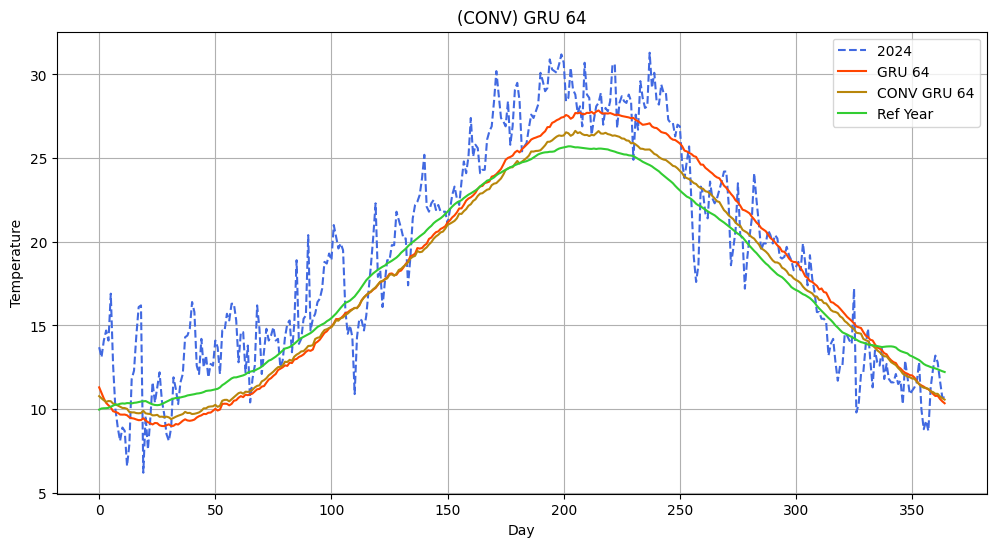

In [27]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_64[:, 2], label="GRU 64", color='orangered')
plt.plot(x, Y_conv_gru_64[:, 2], label="CONV GRU 64", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [40]:
gru_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_128 = gru_128.fit(train_ds, validation_data=valid_ds, epochs=40)
gru_128.save('models/gru_128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 222.5751 - mae: 12.7953 - val_loss: 52.0466 - val_mae: 5.9297
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 45.4325 - mae: 5.6618 - val_loss: 43.4337 - val_mae: 5.6405
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 42.2307 - mae: 5.5422 - val_loss: 43.3738 - val_mae: 5.6403
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 42.2575 - mae: 5.5445 - val_loss: 43.3813 - val_mae: 5.6405
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 42.2353 - mae: 5.5431 - val_loss: 43.4056 - val_mae: 5.6414
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 42.2784 - mae: 5.5461 - val_loss: 43.4352 - val_mae: 5.6429
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 42.2632 - mae: 5.5445 - val_loss: 43.4233 - val_mae: 5.6422
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.2634 - mae: 5.5445 - val_loss: 43.3843 - val_mae: 5.6409
Epoch 9/40
183/183 ━━━━━━━━━━━

In [42]:
from tensorflow.keras.models import load_model
gru_128 = load_model('models/gru_128.keras')
history_gru_128_2 = gru_128.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_128.save('models/gru_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 6.5309 - mae: 1.9452 - val_loss: 6.2179 - val_mae: 1.9332
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 6.4894 - mae: 1.9377 - val_loss: 6.1841 - val_mae: 1.9268
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.4683 - mae: 1.9348 - val_loss: 6.3719 - val_mae: 1.9613
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.4471 - mae: 1.9317 - val_loss: 6.3221 - val_mae: 1.9533
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.4242 - mae: 1.9275 - val_loss: 6.3338 - val_mae: 1.9545
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.4067 - mae: 1.9252 - val_loss: 6.3181 - val_mae: 1.9514
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.3838 - mae: 1.9215 - val_loss: 6.3367 - val_mae: 1.9542
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.3607 - mae: 1.9180 - val_loss: 6.2615 - val_mae: 1.9388
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/

In [43]:
gru_128 = tf.keras.models.load_model('models/gru_128.keras')

Y_gru_128 = gru_128.predict(X)  # shape: (1, 365, 3)
Y_gru_128 = Y_gru_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_128_pred.csv')

mae_gru_128 = mean_absolute_error(Y_test[:, 2], Y_gru_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_128:.3f}')

rmse_gru_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Mean Absolute Error (MAE): 2.458
Root Mean Squared Error (RMSE): 2.961


In [71]:
conv_gru_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_128 = conv_gru_128.fit(train_ds, validation_data=valid_ds, epochs=30)
conv_gru_128.save('models/conv_gru_128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 223.9748 - mae: 12.8456 - val_loss: 52.4706 - val_mae: 5.9458
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 45.6428 - mae: 5.6705 - val_loss: 43.4429 - val_mae: 5.6406
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 42.2542 - mae: 5.5436 - val_loss: 43.3718 - val_mae: 5.6402
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 42.2334 - mae: 5.5429 - val_loss: 43.3885 - val_mae: 5.6410
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 42.2690 - mae: 5.5458 - val_loss: 43.4038 - val_mae: 5.6414
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 42.2798 - mae: 5.5461 - val_loss: 43.4174 - val_mae: 5.6422
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 42.2623 - mae: 5.5434 - val_loss: 43.4317 - val_mae: 5.6425
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 42.2657 - mae: 5.5445 - val_loss: 43.4083 - val_mae: 5.6417
Epoch 9/30
183/183 ━━━━━━━━━━━

In [ ]:
from tensorflow.keras.models import load_model
conv_gru_128 = load_model('models/conv_gru_128.keras')
history_conv_gru_128_2 = conv_gru_128.fit(train_ds, validation_data=valid_ds, epochs=20)
conv_gru_128.save('models/conv_gru_128.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 26.4141 - mae: 4.1691 - val_loss: 26.2981 - val_mae: 4.1919
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 26.2723 - mae: 4.1561 - val_loss: 26.4250 - val_mae: 4.1964
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 26.1409 - mae: 4.1407 - val_loss: 26.2901 - val_mae: 4.1807
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 26.0297 - mae: 4.1275 - val_loss: 26.2945 - val_mae: 4.1778
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 25.9400 - mae: 4.1202 - val_loss: 26.3903 - val_mae: 4.1864
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 25.9701 - mae: 4.1236 - val_loss: 26.3125 - val_mae: 4.1794
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 25.8794 - mae: 4.1147 - val_loss: 26.0337 - val_mae: 4.1584
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 25.6897 - mae: 4.0984 - val_loss: 26.0897 - val_mae: 4.1615
Epoch 9/20
183/183 ━━━━━━━━━━━━━

In [74]:
from tensorflow.keras.models import load_model
conv_gru_128 = load_model('models/conv_gru_128.keras')
history_conv_gru_128_3 = conv_gru_128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_128.save('models/conv_gru_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.7225 - mae: 1.9802 - val_loss: 6.6080 - val_mae: 2.0064
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.6825 - mae: 1.9736 - val_loss: 6.6420 - val_mae: 2.0136
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.6147 - mae: 1.9625 - val_loss: 6.6123 - val_mae: 2.0060
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.5869 - mae: 1.9577 - val_loss: 6.4959 - val_mae: 1.9889
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.5276 - mae: 1.9478 - val_loss: 6.6031 - val_mae: 2.0061
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.5068 - mae: 1.9450 - val_loss: 6.5163 - val_mae: 1.9892
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.4846 - mae: 1.9411 - val_loss: 6.4553 - val_mae: 1.9786
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.4282 - mae: 1.9311 - val_loss: 6.5105 - val_mae: 1.9881
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/

In [76]:
from tensorflow.keras.models import load_model
conv_gru_128 = load_model('models/conv_gru_128.keras')
history_conv_gru_128_4 = conv_gru_128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_128.save('models/conv_gru_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 6.3734 - mae: 1.9228 - val_loss: 6.6011 - val_mae: 2.0042
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.4157 - mae: 1.9306 - val_loss: 6.5199 - val_mae: 1.9887
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.3457 - mae: 1.9180 - val_loss: 6.5318 - val_mae: 1.9963
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.3222 - mae: 1.9144 - val_loss: 6.5003 - val_mae: 1.9875
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.3093 - mae: 1.9119 - val_loss: 6.5470 - val_mae: 1.9971
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.2866 - mae: 1.9086 - val_loss: 6.7087 - val_mae: 2.0251
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.2748 - mae: 1.9066 - val_loss: 6.4811 - val_mae: 1.9874
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.2750 - mae: 1.9062 - val_loss: 6.4964 - val_mae: 1.9893
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/

In [77]:
conv_gru_128 = tf.keras.models.load_model('models/conv_gru_128.keras')

Y_conv_gru_128 = conv_gru_128.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_128 = Y_conv_gru_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_128_pred.csv')

mae_conv_gru_128 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_128:.3f}')

rmse_conv_gru_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Mean Absolute Error (MAE): 2.170
Root Mean Squared Error (RMSE): 2.699


In [44]:
conv_gru_128 = tf.keras.models.load_model('models/conv_gru_128.keras')

Y_conv_gru_128 = conv_gru_128.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_128 = Y_conv_gru_128[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


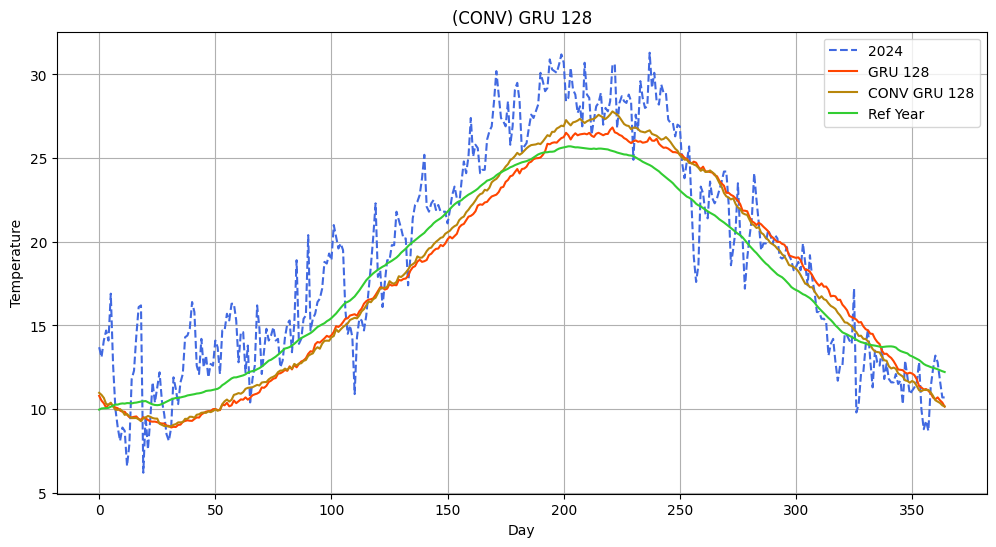

In [45]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_128[:, 2], label="GRU 128", color='orangered')
plt.plot(x, Y_conv_gru_128[:, 2], label="CONV GRU 128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [79]:
gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_3232 = gru_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
gru_3232.save('models/gru_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 312.8932 - mae: 16.0578 - val_loss: 197.4034 - val_mae: 12.1286
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 162.0785 - mae: 10.7995 - val_loss: 109.0050 - val_mae: 8.4745
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 90.8729 - mae: 7.7288 - val_loss: 68.6907 - val_mae: 6.6375
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 59.8203 - mae: 6.2830 - val_loss: 52.1866 - val_mae: 5.9350
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 47.8096 - mae: 5.7542 - val_loss: 46.1422 - val_mae: 5.7205
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 43.7332 - mae: 5.5932 - val_loss: 44.1632 - val_mae: 5.6601
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 42.5804 - mae: 5.5524 - val_loss: 43.5744 - val_mae: 5.6432
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 42.2693 - mae: 5.5414 - val_loss: 43.4082 - val_mae: 5.6399
Epoch 9/60
183/183 ━━━

In [80]:
gru_3232 = tf.keras.models.load_model('models/gru_3232.keras')

Y_gru_3232 = gru_3232.predict(X)  # shape: (1, 365, 3)
Y_gru_3232 = Y_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_3232_pred.csv')

mae_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_3232:.3f}')

rmse_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Mean Absolute Error (MAE): 2.272
Root Mean Squared Error (RMSE): 2.792


In [81]:
conv_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_3232.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_3232 = conv_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=50)
conv_gru_3232.save('models/conv_gru_3232.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 312.9399 - mae: 16.0607 - val_loss: 197.9228 - val_mae: 12.1489
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 162.5356 - mae: 10.8188 - val_loss: 109.3497 - val_mae: 8.4901
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 91.1643 - mae: 7.7426 - val_loss: 68.8743 - val_mae: 6.6458
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 59.9801 - mae: 6.2905 - val_loss: 52.2707 - val_mae: 5.9382
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 47.8775 - mae: 5.7569 - val_loss: 46.1753 - val_mae: 5.7215
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 43.7941 - mae: 5.5966 - val_loss: 44.1759 - val_mae: 5.6605
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 42.6090 - mae: 5.5542 - val_loss: 43.5794 - val_mae: 5.6433
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 42.2961 - mae: 5.5438 - val_loss: 43.4102 - val_mae: 5.6399
Epoch 9/50
183/183 ━━━━━━

In [82]:
from tensorflow.keras.models import load_model
conv_gru_3232 = load_model('models/conv_gru_3232.keras')
history_conv_gru_3232_2 = conv_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_3232.save('models/conv_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 12.2689 - mae: 2.7939 - val_loss: 10.3852 - val_mae: 2.5607
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 9.7334 - mae: 2.4523 - val_loss: 8.5705 - val_mae: 2.3044
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 8.2731 - mae: 2.2353 - val_loss: 7.4006 - val_mae: 2.1308
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 7.4936 - mae: 2.1089 - val_loss: 7.0179 - val_mae: 2.0691
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 7.1076 - mae: 2.0450 - val_loss: 6.8439 - val_mae: 2.0409
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.9422 - mae: 2.0167 - val_loss: 6.6415 - val_mae: 2.0096
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 6.8318 - mae: 1.9988 - val_loss: 6.9339 - val_mae: 2.0675
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.7721 - mae: 1.9893 - val_loss: 6.8425 - val_mae: 2.0450
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31m

In [83]:
conv_gru_3232 = tf.keras.models.load_model('models/conv_gru_3232.keras')

Y_conv_gru_3232 = conv_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_3232 = Y_conv_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_3232_pred.csv')

mae_conv_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_3232:.3f}')

rmse_conv_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Mean Absolute Error (MAE): 1.960
Root Mean Squared Error (RMSE): 2.494


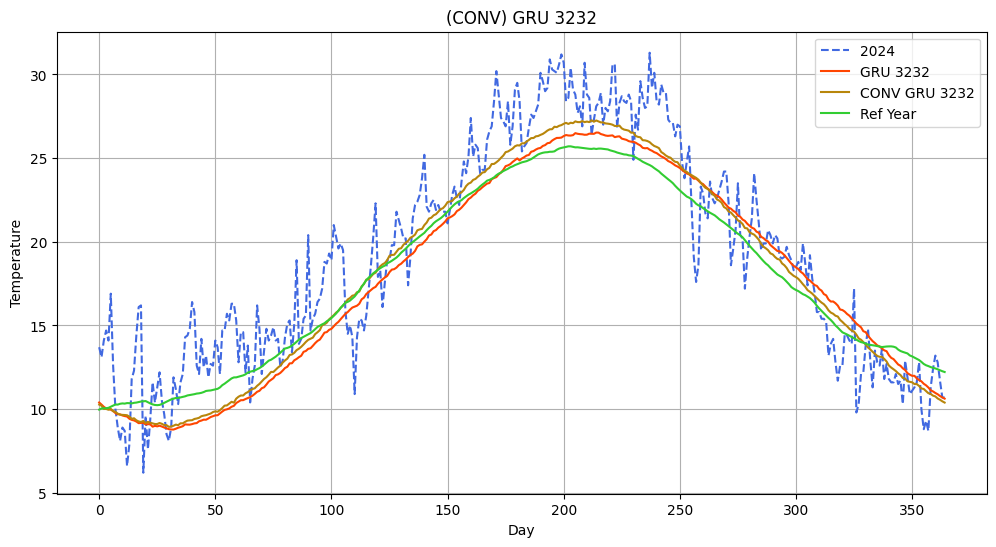

In [84]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_3232[:, 2], label="GRU 3232", color='orangered')
plt.plot(x, Y_conv_gru_3232[:, 2], label="CONV GRU 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [85]:
gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_6464 = gru_6464.fit(train_ds, validation_data=valid_ds, epochs=50)
gru_6464.save('models/gru_6464.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 274.8335 - mae: 14.7597 - val_loss: 109.5745 - val_mae: 8.4995
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 83.0097 - mae: 7.3613 - val_loss: 52.5401 - val_mae: 5.9484
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 46.9837 - mae: 5.7215 - val_loss: 44.2963 - val_mae: 5.6641
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 42.5630 - mae: 5.5518 - val_loss: 43.4414 - val_mae: 5.6405
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 42.2372 - mae: 5.5416 - val_loss: 43.3607 - val_mae: 5.6396
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 42.2368 - mae: 5.5434 - val_loss: 43.3480 - val_mae: 5.6395
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 42.1928 - mae: 5.5401 - val_loss: 43.3509 - val_mae: 5.6396
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 42.2260 - mae: 5.5424 - val_loss: 43.3610 - val_mae: 5.6399
Epoch 9/50
183/183 ━━━━━━━

In [86]:
from tensorflow.keras.models import load_model
gru_6464 = load_model('models/gru_6464.keras')
history_gru_6464_2 = gru_6464.fit(train_ds, validation_data=valid_ds, epochs=20)
gru_6464.save('models/gru_6464.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 22.2676 - mae: 3.8963 - val_loss: 16.2441 - val_mae: 3.2910
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 14.6057 - mae: 3.0795 - val_loss: 10.6859 - val_mae: 2.6081
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 10.2808 - mae: 2.5284 - val_loss: 7.9900 - val_mae: 2.2188
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 8.2542 - mae: 2.2294 - val_loss: 6.9144 - val_mae: 2.0499
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 7.3232 - mae: 2.0822 - val_loss: 6.3392 - val_mae: 1.9627
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 6.9656 - mae: 2.0222 - val_loss: 6.1354 - val_mae: 1.9244
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 6.8049 - mae: 1.9953 - val_loss: 6.0419 - val_mae: 1.9063
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 6.7496 - mae: 1.9853 - val_loss: 6.0292 - val_mae: 1.9037
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 

In [87]:
gru_6464 = tf.keras.models.load_model('models/gru_6464.keras')

Y_gru_6464 = gru_6464.predict(X)  # shape: (1, 365, 3)
Y_gru_6464 = Y_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_6464_pred.csv')

mae_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_6464:.3f}')

rmse_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Mean Absolute Error (MAE): 2.093
Root Mean Squared Error (RMSE): 2.576


In [88]:
conv_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_6464.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_6464 = conv_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_6464.save('models/conv_gru_6464.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 274.9334 - mae: 14.7598 - val_loss: 109.0804 - val_mae: 8.4771
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 82.6622 - mae: 7.3457 - val_loss: 52.4098 - val_mae: 5.9434
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 46.8864 - mae: 5.7181 - val_loss: 44.2808 - val_mae: 5.6636
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 42.5318 - mae: 5.5502 - val_loss: 43.4355 - val_mae: 5.6404
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 42.2379 - mae: 5.5423 - val_loss: 43.3560 - val_mae: 5.6395
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 42.1917 - mae: 5.5398 - val_loss: 43.3499 - val_mae: 5.6395
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.2326 - mae: 5.5432 - val_loss: 43.3499 - val_mae: 5.6396
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 42.2316 - mae: 5.5420 - val_loss: 43.3599 - val_mae: 5.6398
Epoch 9/40
183/183 ━━━━━━━━━━

In [89]:
conv_gru_6464 = tf.keras.models.load_model('models/conv_gru_6464.keras')

Y_conv_gru_6464 = conv_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_6464 = Y_conv_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_6464_pred.csv')

mae_conv_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_6464:.3f}')

rmse_conv_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Mean Absolute Error (MAE): 1.874
Root Mean Squared Error (RMSE): 2.360


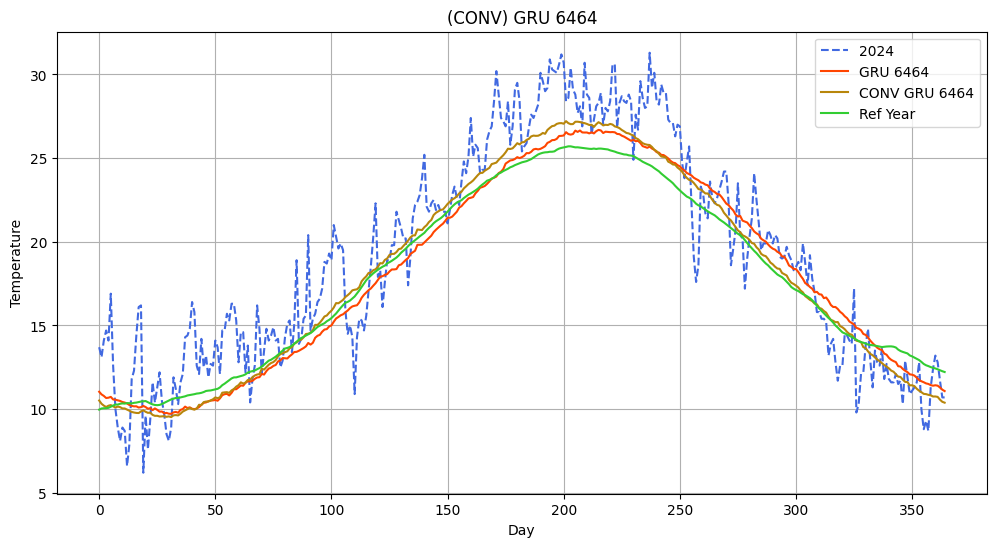

In [90]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_6464[:, 2], label="GRU 6464", color='orangered')
plt.plot(x, Y_conv_gru_6464[:, 2], label="CONV GRU 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [91]:
gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_128128 = gru_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
gru_128128.save('models/gru_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 222.8858 - mae: 12.7924 - val_loss: 51.4182 - val_mae: 5.9064
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 45.1826 - mae: 5.6522 - val_loss: 43.4325 - val_mae: 5.6406
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 42.2344 - mae: 5.5423 - val_loss: 43.3657 - val_mae: 5.6401
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 42.2500 - mae: 5.5438 - val_loss: 43.3696 - val_mae: 5.6401
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 42.2481 - mae: 5.5437 - val_loss: 43.3932 - val_mae: 5.6410
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 42.2668 - mae: 5.5455 - val_loss: 43.3967 - val_mae: 5.6410
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 42.2584 - mae: 5.5440 - val_loss: 43.4365 - val_mae: 5.6427
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 42.2865 - mae: 5.5460 - val_loss: 43.4229 - val_mae: 5.6420
Epoch 9/40
183/183 ━━━━━━━━━━

In [92]:
from tensorflow.keras.models import load_model
gru_128128 = load_model('models/gru_128128.keras')
history_gru_128128_2 = gru_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_128128.save('models/gru_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 6.9977 - mae: 2.0236 - val_loss: 6.3488 - val_mae: 1.9611
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 6.8355 - mae: 1.9971 - val_loss: 6.2578 - val_mae: 1.9415
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 6.7323 - mae: 1.9797 - val_loss: 6.2507 - val_mae: 1.9390
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 6.6840 - mae: 1.9722 - val_loss: 6.2770 - val_mae: 1.9450
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 6.6300 - mae: 1.9642 - val_loss: 6.5632 - val_mae: 1.9988
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 6.5792 - mae: 1.9548 - val_loss: 6.3238 - val_mae: 1.9553
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 6.5428 - mae: 1.9485 - val_loss: 6.6055 - val_mae: 2.0045
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 6.5191 - mae: 1.9453 - val_loss: 6.4645 - val_mae: 1.9786
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44

In [93]:
gru_128128 = tf.keras.models.load_model('models/gru_128128.keras')

Y_gru_128128 = gru_128128.predict(X)  # shape: (1, 365, 3)
Y_gru_128128 = Y_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_128128_pred.csv')

mae_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_128128:.3f}')

rmse_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Mean Absolute Error (MAE): 2.235
Root Mean Squared Error (RMSE): 2.748


In [94]:
conv_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_128128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_128128 = conv_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=30)
conv_gru_128128.save('models/conv_gru_128128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 222.0500 - mae: 12.7677 - val_loss: 51.3100 - val_mae: 5.9024
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 45.0933 - mae: 5.6479 - val_loss: 43.4259 - val_mae: 5.6404
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 42.2205 - mae: 5.5420 - val_loss: 43.3774 - val_mae: 5.6404
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 42.2445 - mae: 5.5435 - val_loss: 43.3680 - val_mae: 5.6403
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 42.2377 - mae: 5.5435 - val_loss: 43.4041 - val_mae: 5.6413
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.2607 - mae: 5.5448 - val_loss: 43.3850 - val_mae: 5.6408
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 42.2733 - mae: 5.5458 - val_loss: 43.3923 - val_mae: 5.6407
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.2878 - mae: 5.5464 - val_loss: 43.3962 - val_mae: 5.6410
Epoch 9/30
183/183 ━━━━━━━━━━━

In [28]:
from tensorflow.keras.models import load_model
conv_gru_128128 = load_model('models/conv_gru_128128.keras')
history_conv_gru_128128_2 = conv_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_128128.save('models/conv_gru_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 6.3982 - mae: 1.9262 - val_loss: 6.1892 - val_mae: 1.9372
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 6.3436 - mae: 1.9169 - val_loss: 6.1348 - val_mae: 1.9274
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 6.3232 - mae: 1.9133 - val_loss: 5.9957 - val_mae: 1.9006
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 6.2913 - mae: 1.9085 - val_loss: 6.0542 - val_mae: 1.9093
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 6.3286 - mae: 1.9152 - val_loss: 6.0740 - val_mae: 1.9157
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.2588 - mae: 1.9034 - val_loss: 6.1696 - val_mae: 1.9313
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.2420 - mae: 1.9003 - val_loss: 6.1768 - val_mae: 1.9315
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.2371 - mae: 1.8999 - val_loss: 6.1147 - val_mae: 1.9212
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/

In [29]:
conv_gru_128128 = tf.keras.models.load_model('models/conv_gru_128128.keras')

Y_conv_gru_128128 = conv_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_128128 = Y_conv_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_128128_pred.csv')

mae_conv_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_128128:.3f}')

rmse_conv_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Mean Absolute Error (MAE): 2.151
Root Mean Squared Error (RMSE): 2.638


In [30]:
gru_128128 = tf.keras.models.load_model('models/gru_128128.keras')

Y_gru_128128 = gru_128128.predict(X)  # shape: (1, 365, 3)
Y_gru_128128 = Y_gru_128128[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


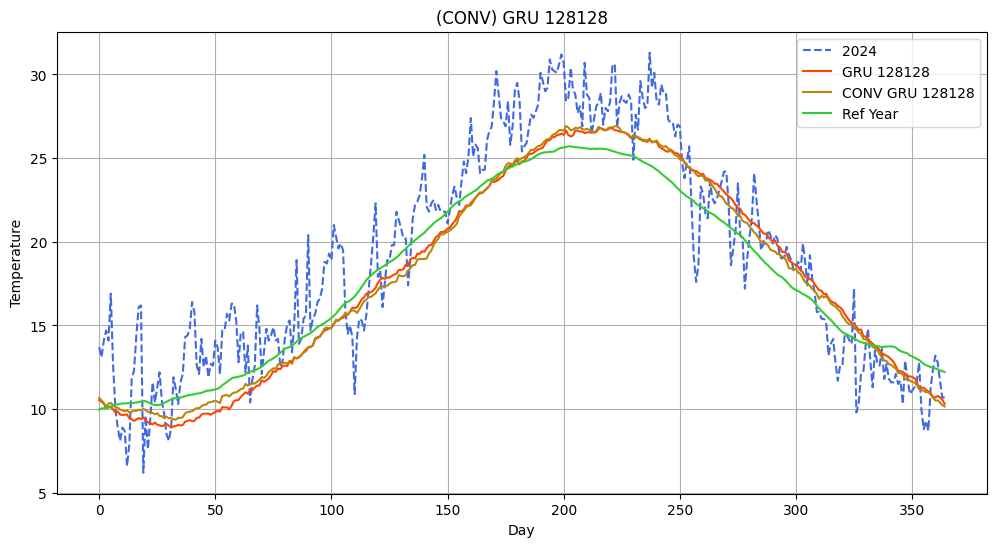

In [31]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_128128[:, 2], label="GRU 128128", color='orangered')
plt.plot(x, Y_conv_gru_128128[:, 2], label="CONV GRU 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_3232 = lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=80)
lstm_gru_3232.save('models/lstm_gru_3232.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 311.6568 - mae: 16.0103 - val_loss: 189.6643 - val_mae: 11.8297
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 154.9749 - mae: 10.5086 - val_loss: 103.6498 - val_mae: 8.2333
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 86.5048 - mae: 7.5258 - val_loss: 65.8774 - val_mae: 6.5112
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 57.6457 - mae: 6.1831 - val_loss: 50.9431 - val_mae: 5.8884
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 46.9573 - mae: 5.7197 - val_loss: 45.6650 - val_mae: 5.7058
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 43.4520 - mae: 5.5837 - val_loss: 44.0014 - val_mae: 5.6552
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 42.4653 - mae: 5.5476 - val_loss: 43.5250 - val_mae: 5.6420
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 42.2542 - mae: 5.5421 - val_loss: 43.3930 - val_mae: 5.6397
Epoch 9/80
183/183 ━━

In [14]:
from tensorflow.keras.models import load_model
lstm_gru_3232 = load_model('models/lstm_gru_3232.keras')
history_lstm_gru_3232_2 = lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_gru_3232.save('models/lstm_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 6.8636 - mae: 2.0031 - val_loss: 6.2618 - val_mae: 1.9389
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 6.7741 - mae: 1.9877 - val_loss: 6.2427 - val_mae: 1.9334
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 6.7612 - mae: 1.9862 - val_loss: 6.1440 - val_mae: 1.9203
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 6.7533 - mae: 1.9842 - val_loss: 6.3204 - val_mae: 1.9525
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 6.8233 - mae: 1.9971 - val_loss: 6.3630 - val_mae: 1.9526
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 6.7414 - mae: 1.9832 - val_loss: 6.3200 - val_mae: 1.9505
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 6.7098 - mae: 1.9776 - val_loss: 6.1530 - val_mae: 1.9236
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 6.6692 - mae: 1.9705 - val_loss: 6.2107 - val_mae: 1.9303
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms

In [15]:
lstm_gru_3232 = tf.keras.models.load_model('models/lstm_gru_3232.keras')

Y_lstm_gru_3232 = lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_3232 = Y_lstm_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_3232_pred.csv')

mae_lstm_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_3232:.3f}')

rmse_lstm_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Mean Absolute Error (MAE): 2.087
Root Mean Squared Error (RMSE): 2.615


In [9]:
conv_lstm_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_3232 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 312.4968 - mae: 16.0413 - val_loss: 191.8574 - val_mae: 11.9179
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 156.9756 - mae: 10.5926 - val_loss: 105.0024 - val_mae: 8.2948
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 87.6188 - mae: 7.5776 - val_loss: 66.5408 - val_mae: 6.5405
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 58.1630 - mae: 6.2069 - val_loss: 51.2191 - val_mae: 5.8987
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 47.1173 - mae: 5.7256 - val_loss: 45.7674 - val_mae: 5.7089
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 43.5050 - mae: 5.5851 - val_loss: 44.0366 - val_mae: 5.6562
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 42.4865 - mae: 5.5487 - val_loss: 43.5349 - val_mae: 5.6422
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 42.2569 - mae: 5.5415 - val_loss: 43.3959 - val_mae: 5.6397
Epoch 9/60
183/183 ━━━━━━

In [10]:
from tensorflow.keras.models import load_model
conv_lstm_gru_3232 = load_model('models/conv_lstm_gru_3232.keras')
history_conv_lstm_gru_3232_2 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 8.5176 - mae: 2.2695 - val_loss: 7.9350 - val_mae: 2.2196
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 7.8029 - mae: 2.1552 - val_loss: 7.4000 - val_mae: 2.1363
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 7.3538 - mae: 2.0816 - val_loss: 6.8662 - val_mae: 2.0522
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 7.0964 - mae: 2.0384 - val_loss: 6.9341 - val_mae: 2.0629
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.9370 - mae: 2.0132 - val_loss: 6.5697 - val_mae: 2.0008
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.8309 - mae: 1.9956 - val_loss: 6.4019 - val_mae: 1.9741
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.7609 - mae: 1.9844 - val_loss: 6.6923 - val_mae: 2.0206
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.7157 - mae: 1.9778 - val_loss: 6.4270 - val_mae: 1.9760
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/

In [12]:
from tensorflow.keras.models import load_model
conv_lstm_gru_3232 = load_model('models/conv_lstm_gru_3232.keras')
history_conv_lstm_gru_3232_3 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 6.6224 - mae: 1.9625 - val_loss: 6.3084 - val_mae: 1.9539
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 6.5970 - mae: 1.9582 - val_loss: 6.3703 - val_mae: 1.9645
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 6.5895 - mae: 1.9575 - val_loss: 6.1949 - val_mae: 1.9326
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.5775 - mae: 1.9550 - val_loss: 6.1792 - val_mae: 1.9268
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 6.5607 - mae: 1.9520 - val_loss: 6.1512 - val_mae: 1.9215
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.5635 - mae: 1.9525 - val_loss: 6.2117 - val_mae: 1.9372
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.5518 - mae: 1.9507 - val_loss: 6.0915 - val_mae: 1.9118
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 6.5420 - mae: 1.9489 - val_loss: 6.2796 - val_mae: 1.9422
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/

In [32]:
from tensorflow.keras.models import load_model
conv_lstm_gru_3232 = load_model('models/conv_lstm_gru_3232.keras')
history_conv_lstm_gru_3232_4 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 6.5143 - mae: 1.9440 - val_loss: 6.1213 - val_mae: 1.9133
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 6.4989 - mae: 1.9412 - val_loss: 6.4998 - val_mae: 1.9800
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 6.4950 - mae: 1.9410 - val_loss: 6.3702 - val_mae: 1.9552
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 6.4739 - mae: 1.9371 - val_loss: 6.5455 - val_mae: 1.9865
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 6.4672 - mae: 1.9363 - val_loss: 6.3645 - val_mae: 1.9571
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.4486 - mae: 1.9329 - val_loss: 6.3707 - val_mae: 1.9580
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 6.4285 - mae: 1.9295 - val_loss: 6.3103 - val_mae: 1.9466
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 6.4239 - mae: 1.9287 - val_loss: 6.3359 - val_mae: 1.9527
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/

In [33]:
conv_lstm_gru_3232 = tf.keras.models.load_model('models/conv_lstm_gru_3232.keras')

Y_conv_lstm_gru_3232 = conv_lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_3232 = Y_conv_lstm_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_3232_pred.csv')

mae_conv_lstm_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_3232:.3f}')

rmse_conv_lstm_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Mean Absolute Error (MAE): 2.235
Root Mean Squared Error (RMSE): 2.726


In [34]:
lstm_gru_3232 = tf.keras.models.load_model('models/lstm_gru_3232.keras')

Y_lstm_gru_3232 = lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_3232 = Y_lstm_gru_3232[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


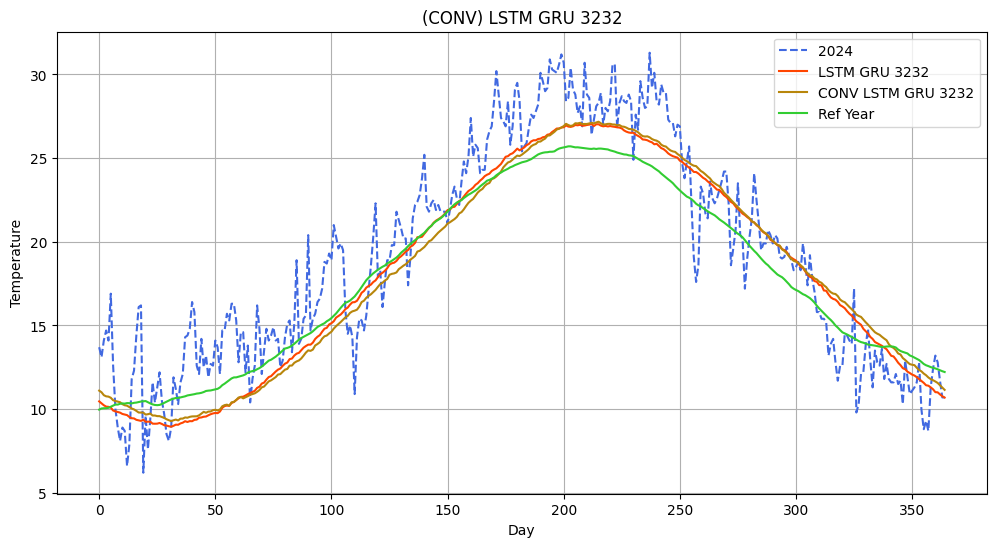

In [35]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_3232[:, 2], label="LSTM GRU 3232", color='orangered')
plt.plot(x, Y_conv_lstm_gru_3232[:, 2], label="CONV LSTM GRU 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [17]:
lstm_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_6464= lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_gru_6464.save('models/lstm_gru_6464.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 274.1196 - mae: 14.7201 - val_loss: 104.6922 - val_mae: 8.2802
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 79.4014 - mae: 7.1949 - val_loss: 51.2626 - val_mae: 5.9005
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 46.1942 - mae: 5.6893 - val_loss: 44.1107 - val_mae: 5.6584
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 42.4841 - mae: 5.5496 - val_loss: 43.4188 - val_mae: 5.6401
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 42.2124 - mae: 5.5408 - val_loss: 43.3599 - val_mae: 5.6396
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 42.2442 - mae: 5.5440 - val_loss: 43.3590 - val_mae: 5.6399
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 42.2128 - mae: 5.5415 - val_loss: 43.3572 - val_mae: 5.6398
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 42.2213 - mae: 5.5421 - val_loss: 43.3463 - val_mae: 5.6395
Epoch 9/60
183/183 ━━━━━━━━━

In [18]:
from tensorflow.keras.models import load_model
lstm_gru_6464 = load_model('models/lstm_gru_6464.keras')
history_lstm_gru_6464_2 = lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_gru_6464.save('models/lstm_gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 6.9748 - mae: 2.0195 - val_loss: 6.7554 - val_mae: 2.0259
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 6.8127 - mae: 1.9926 - val_loss: 6.4200 - val_mae: 1.9685
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 6.7249 - mae: 1.9785 - val_loss: 6.6082 - val_mae: 1.9979
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 6.6935 - mae: 1.9737 - val_loss: 6.1867 - val_mae: 1.9258
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 6.6473 - mae: 1.9660 - val_loss: 6.2181 - val_mae: 1.9311
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 6.5993 - mae: 1.9581 - val_loss: 6.3215 - val_mae: 1.9478
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 6.5714 - mae: 1.9540 - val_loss: 6.4719 - val_mae: 1.9754
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 6.5524 - mae: 1.9509 - val_loss: 6.5195 - val_mae: 1.9820
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45

In [19]:
lstm_gru_6464 = tf.keras.models.load_model('models/lstm_gru_6464.keras')

Y_lstm_gru_6464 = lstm_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_6464 = Y_lstm_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_6464_pred.csv')

mae_lstm_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_6464:.3f}')

rmse_lstm_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Mean Absolute Error (MAE): 2.258
Root Mean Squared Error (RMSE): 2.781


In [20]:
conv_lstm_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_6464 = conv_lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_gru_6464.save('models/conv_lstm_gru_6464.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 274.1731 - mae: 14.7220 - val_loss: 105.2765 - val_mae: 8.3059
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 79.8447 - mae: 7.2149 - val_loss: 51.4317 - val_mae: 5.9068
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 46.3127 - mae: 5.6943 - val_loss: 44.1334 - val_mae: 5.6592
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 42.5218 - mae: 5.5518 - val_loss: 43.4180 - val_mae: 5.6400
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 42.2263 - mae: 5.5416 - val_loss: 43.3601 - val_mae: 5.6397
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 42.2391 - mae: 5.5429 - val_loss: 43.3533 - val_mae: 5.6397
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 42.2353 - mae: 5.5432 - val_loss: 43.3469 - val_mae: 5.6395
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 42.2362 - mae: 5.5432 - val_loss: 43.3634 - val_mae: 5.6400
Epoch 9/40
183/183 ━━━━━━━━━━

In [21]:
from tensorflow.keras.models import load_model
conv_lstm_gru_6464 = load_model('models/conv_lstm_gru_6464.keras')
history_conv_lstm_gru_6464_2 = conv_lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=20)
conv_lstm_gru_6464.save('models/conv_lstm_gru_6464.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 42.3006 - mae: 5.5463 - val_loss: 42.9427 - val_mae: 5.6083
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 40.7940 - mae: 5.4381 - val_loss: 37.5575 - val_mae: 5.2157
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 35.1012 - mae: 5.0077 - val_loss: 31.3921 - val_mae: 4.7199
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 29.5205 - mae: 4.5382 - val_loss: 27.6677 - val_mae: 4.3800
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 25.5051 - mae: 4.1714 - val_loss: 20.4291 - val_mae: 3.7344
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 17.8476 - mae: 3.4304 - val_loss: 12.8924 - val_mae: 2.8898
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 11.2982 - mae: 2.6599 - val_loss: 8.8592 - val_mae: 2.3529
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 8.6827 - mae: 2.2915 - val_loss: 7.5731 - val_mae: 2.1640
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━

In [22]:
conv_lstm_gru_6464 = tf.keras.models.load_model('models/conv_lstm_gru_6464.keras')

Y_conv_lstm_gru_6464 = conv_lstm_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_6464 = Y_conv_lstm_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_6464_pred.csv')

mae_conv_lstm_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_6464:.3f}')

rmse_conv_lstm_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
Mean Absolute Error (MAE): 2.165
Root Mean Squared Error (RMSE): 2.683


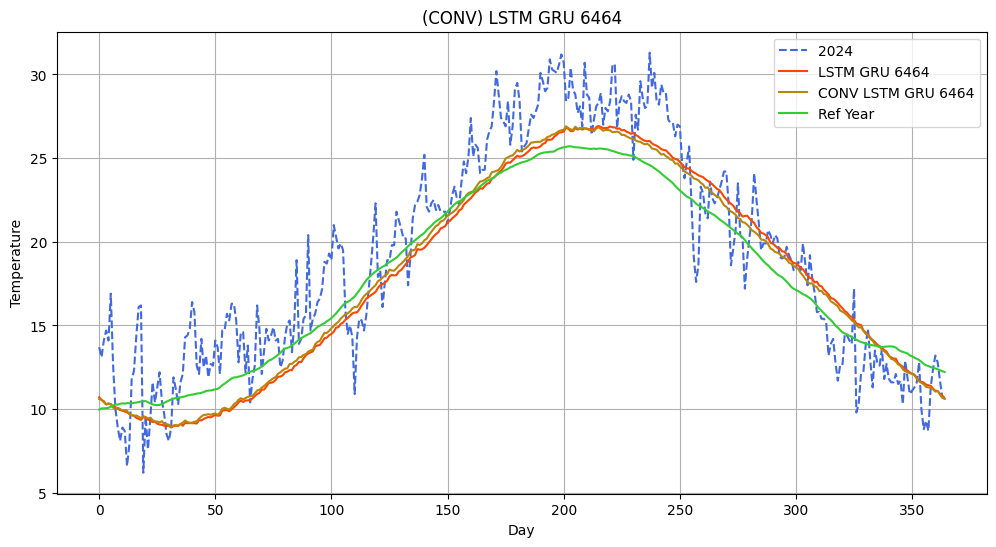

In [23]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_6464[:, 2], label="LSTM GRU 6464", color='orangered')
plt.plot(x, Y_conv_lstm_gru_6464[:, 2], label="CONV LSTM GRU 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [24]:
lstm_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_128128= lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
lstm_gru_128128.save('models/lstm_gru_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 221.2076 - mae: 12.7224 - val_loss: 50.5408 - val_mae: 5.8739
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 44.7669 - mae: 5.6353 - val_loss: 43.4149 - val_mae: 5.6403
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 42.2576 - mae: 5.5443 - val_loss: 43.3790 - val_mae: 5.6404
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 42.2761 - mae: 5.5463 - val_loss: 43.3783 - val_mae: 5.6404
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 42.2410 - mae: 5.5433 - val_loss: 43.3712 - val_mae: 5.6402
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 42.2624 - mae: 5.5444 - val_loss: 43.4038 - val_mae: 5.6416
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 42.2456 - mae: 5.5438 - val_loss: 43.3938 - val_mae: 5.6410
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 42.2787 - mae: 5.5451 - val_loss: 43.4106 - val_mae: 5.6416
Epoch 9/40
183/183 ━━━━━━━━━━

In [25]:
from tensorflow.keras.models import load_model
lstm_gru_128128 = load_model('models/lstm_gru_128128.keras')
history_lstm_gru_128128_2 = lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_gru_128128.save('models/lstm_gru_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 7.0922 - mae: 2.0388 - val_loss: 6.6619 - val_mae: 2.0206
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 7.0330 - mae: 2.0308 - val_loss: 6.6907 - val_mae: 2.0215
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 6.9031 - mae: 2.0087 - val_loss: 6.3194 - val_mae: 1.9572
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 6.8454 - mae: 1.9995 - val_loss: 6.3576 - val_mae: 1.9680
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 6.7593 - mae: 1.9853 - val_loss: 6.0909 - val_mae: 1.9197
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 6.7293 - mae: 1.9800 - val_loss: 6.3161 - val_mae: 1.9600
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 6.7028 - mae: 1.9761 - val_loss: 6.3747 - val_mae: 1.9724
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 6.6437 - mae: 1.9662 - val_loss: 6.2517 - val_mae: 1.9518
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms

In [27]:
from tensorflow.keras.models import load_model
lstm_gru_128128 = load_model('models/lstm_gru_128128.keras')
history_lstm_gru_128128_3 = lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_gru_128128.save('models/lstm_gru_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 6.5624 - mae: 1.9518 - val_loss: 6.3592 - val_mae: 1.9733
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 6.5574 - mae: 1.9512 - val_loss: 6.7467 - val_mae: 2.0444
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 6.5551 - mae: 1.9509 - val_loss: 6.4127 - val_mae: 1.9794
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 6.4919 - mae: 1.9403 - val_loss: 6.5564 - val_mae: 2.0082
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 6.4563 - mae: 1.9343 - val_loss: 6.4596 - val_mae: 1.9895
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 6.4376 - mae: 1.9313 - val_loss: 6.4536 - val_mae: 1.9854
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 6.4222 - mae: 1.9291 - val_loss: 6.6380 - val_mae: 2.0152
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 6.3991 - mae: 1.9253 - val_loss: 6.4664 - val_mae: 1.9836
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms

In [28]:
lstm_gru_128128 = tf.keras.models.load_model('models/lstm_gru_128128.keras')

Y_lstm_gru_128128 = lstm_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_128128 = Y_lstm_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_128128_pred.csv')

mae_lstm_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_128128:.3f}')

rmse_lstm_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Mean Absolute Error (MAE): 2.200
Root Mean Squared Error (RMSE): 2.725


In [33]:
conv_lstm_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_128128 = conv_lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=30)
conv_lstm_gru_128128.save('models/conv_lstm_gru_128128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 222.0398 - mae: 12.7560 - val_loss: 50.8300 - val_mae: 5.8846
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 44.8869 - mae: 5.6400 - val_loss: 43.4232 - val_mae: 5.6405
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 42.2572 - mae: 5.5442 - val_loss: 43.3822 - val_mae: 5.6405
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 42.2324 - mae: 5.5428 - val_loss: 43.3752 - val_mae: 5.6403
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.2605 - mae: 5.5441 - val_loss: 43.3797 - val_mae: 5.6405
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 42.2763 - mae: 5.5460 - val_loss: 43.4008 - val_mae: 5.6413
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.2924 - mae: 5.5460 - val_loss: 43.3696 - val_mae: 5.6404
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.2859 - mae: 5.5462 - val_loss: 43.4522 - val_mae: 5.6431
Epoch 9/30
183/183 ━━━━━━━━━━━

In [34]:
from tensorflow.keras.models import load_model
conv_lstm_gru_128128 = load_model('models/conv_lstm_gru_128128.keras')
history_conv_lstm_gru_128128_2 = conv_lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_128128.save('models/conv_lstm_gru_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 30.2235 - mae: 4.5914 - val_loss: 25.6408 - val_mae: 4.2096
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 21.5550 - mae: 3.7864 - val_loss: 12.6812 - val_mae: 2.8593
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.4590 - mae: 2.6740 - val_loss: 8.0712 - val_mae: 2.2290
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 8.3076 - mae: 2.2317 - val_loss: 6.8392 - val_mae: 2.0408
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 7.4422 - mae: 2.0957 - val_loss: 6.3958 - val_mae: 1.9667
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 7.1534 - mae: 2.0501 - val_loss: 6.3184 - val_mae: 1.9576
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.9028 - mae: 2.0083 - val_loss: 6.0261 - val_mae: 1.9056
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.8006 - mae: 1.9913 - val_loss: 6.1898 - val_mae: 1.9334
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [35]:
conv_lstm_gru_128128 = tf.keras.models.load_model('models/conv_lstm_gru_128128.keras')

Y_conv_lstm_gru_128128 = conv_lstm_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_128128 = Y_conv_lstm_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_128128_pred.csv')

mae_conv_lstm_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_128128:.3f}')

rmse_conv_lstm_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Mean Absolute Error (MAE): 1.978
Root Mean Squared Error (RMSE): 2.499


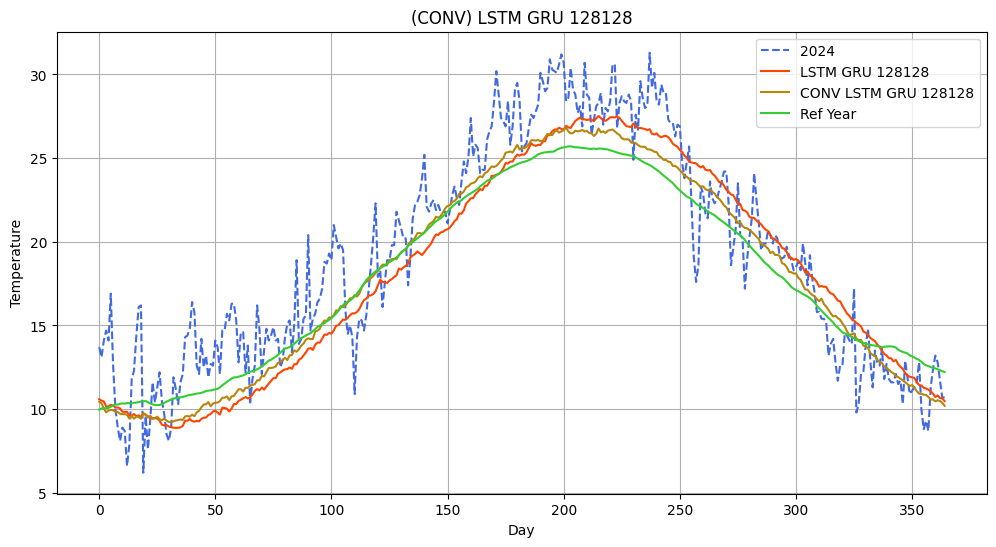

In [36]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_128128[:, 2], label="LSTM GRU 128128", color='orangered')
plt.plot(x, Y_conv_lstm_gru_128128[:, 2], label="CONV LSTM GRU 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 